# Evaluating the QDCA on real quantum hardware

In [3]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import qiskit
import copy

import qcopt

#from ansatz import dqv_cut_ansatz

from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler
from qiskit_ibm_runtime.options import SimulatorOptions, TranspilationOptions

from circuit_knitting_toolbox.circuit_cutting.wire_cutting import verify

import remote_runtime, runtime_helpers, my_noise_models

In [4]:
from matplotlib import rcParams
rcParams["font.family"] = "Times New Roman"
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']

## Step 1: Generate a circuit

### Pick a target graph

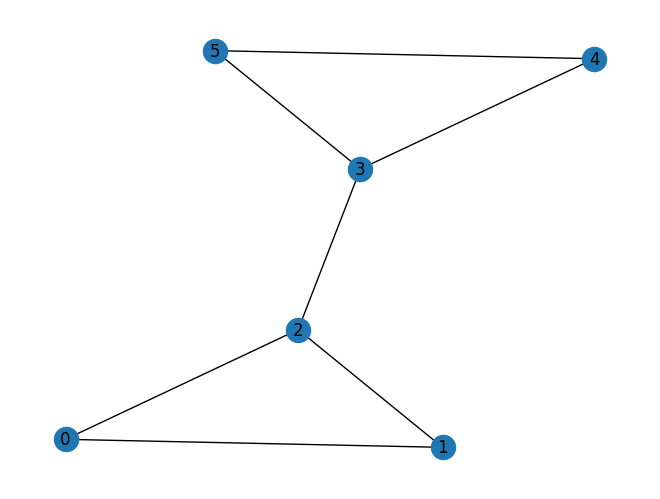

In [100]:
#target_graph = (
#    "/Users/teague/Workspace/dqva-and-circuit-cutting/"
#    "benchmark_graphs/N10_p20_graphs/G12.txt"
#)
G = nx.Graph()
#G.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5),
#                  (4,5), (4,6), (6,7), (5,7), (0,9), (2,9), (8,1), (8,0)])
G.add_edges_from([(0,1), (1,2), (0,2), (2,3), (3,4), (4,5), (3,5)])


#print(target_graph)
#G = qcopt.graph_funcs.graph_from_file(target_graph)
nx.draw_spring(G, with_labels=True)

### Partition the target graph

In [7]:
partition = nx.algorithms.community.kernighan_lin_bisection(G)
subgraphs, cut_edges = get_subgraphs(G, partition)
print(len(subgraphs), cut_edges, partition)

# identify the subgraph of every node
subgraph_dict = {}
for i, subgraph in enumerate(subgraphs):
    for qubit in subgraph:
        subgraph_dict[qubit] = i

2 [(2, 3)] ({0, 1, 2}, {3, 4, 5})


### Decide which partial mixers will cross the cut

In [114]:
# Select hot nodes
max_cuts = 1
cut_nodes, hot_nodes = simple_choose_nodes(G, partition, cut_edges, max_cuts)
print(cut_nodes, hot_nodes)

[2, 3] [2]


### Construct the circuit

In [117]:
barriers = 0
decompose_level = 2

# Put active mixers at the front of the order
cur_permutation = sort_mixers(G, subgraph_dict)
active_mixers = [node for node in cur_permutation if node not in cut_nodes] + hot_nodes
inactive_mixers = [node for node in cur_permutation if node not in active_mixers]
active_mixer_order = [node for node in cur_permutation if node in active_mixers] + inactive_mixers
print(active_mixer_order)
print(partition)

test_params = [i+1 for i in range(len(active_mixers))] + [1]

qaoa = qcopt.qlsa.gen_qlsa(
    G,
    P=1,
    params=test_params,
    barriers=barriers,
    init_state='0'*len(G.nodes),
    decompose_toffoli=decompose_level,
    mixer_order=active_mixer_order,
    param_lim=len(active_mixers)+1,
)
qaoa.draw(fold=-1)

[4, 5, 0, 1, 2, 3]
({3, 4, 5}, {0, 1, 2})


global phase: 0.28319
      ┌─────────┐ ┌───────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌─────────┐ ┌────────────┐ ┌─────────┐  ┌───┐┌──────────┐┌───┐┌─────────┐ ┌───┐┌──────────┐┌───┐┌─────────┐ ┌─────────┐ ┌──────────┐┌───────────┐                                                                                                                             ┌─────────┐                                                                                                                        ┌─────────┐                         ┌───────────┐ ┌───────────┐ ┌─────────────┐   ┌───┐   ┌──────────────┐┌───┐                                                                                                                                                                               ┌─────────────┐                                             ┌───┐     ┌──────────────┐     ┌───┐                                                                                                                                                                                     ┌───────────┐ ┌───────┐                                                           
q_0: ─┤ U1(π/2) ├─┤ U3(4,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U3(-4,0,0) ├─┤ U2(0,π) ├──┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├─┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├─┤ U2(0,π) ├─┤ U1(-π/2) ├┤ U3(π,0,π) ├─────────────────────────────────────────────────────────────────────■────────────────────────────────────■───────────────■──┤ U1(π/4) ├────────────────────■─────────────────────────────────────────────■─────────────────────────────────■────────────────■──┤ U1(π/4) ├──────────────────■──────┤ U3(π,0,π) ├─┤ U3(π,0,π) ├─┤ U3(0,0,π/8) ├───┤ X ├───┤ U3(0,0,-π/8) ├┤ X ├──■────────────────────────────────────────■──────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────■──┤ U3(0,0,π/8) ├─────────────────────────────────────────────┤ X ├─────┤ U3(0,0,-π/8) ├─────┤ X ├───────■────────────────────────────────────────■──────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────■───┤ U3(π,0,π) ├─┤ U1(2) ├───────────────────────────────────────────────────────────
     ┌┴─────────┴┐└───────────┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘├─────────┤ └────────────┘ └─────────┘  └─┬─┘└──────────┘└─┬─┘└─────────┘ └─┬─┘└──────────┘└─┬─┘└─────────┘ ├─────────┤ └──────────┘├───────────┤ ┌─────────┐ ┌───────────┐┌─────────┐    ┌───┐     ┌──────────┐    ┌─┴─┐    ┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  ├─────────┤ ┌────────────┐     │     ┌─────────┐     ┌───┐     ┌──────────┐┌─┴─┐┌─────────┐ ┌───┐┌──────────┐┌─┴─┐┌─────────┐   │  ├─────────┤ ┌──────────┐     │      ├───────────┤┌┴───────────┴┐└─────────────┘   └─┬─┘   └──────────────┘└─┬─┘  │                                        │                                              │                                                                                 │  └─────────────┘                          ┌─────────────┐    └─┬─┘     └──────────────┘     └─┬─┘       │                                        │                                              │                                                                                 │   └───────────┘ └───────┘                         ┌───────────┐ ┌───────┐           
q_1: ┤ U3(π,0,π) ├──────────────────────────┼────────────────■───────────────┼────────────────■───────■─────┤ U1(π/4) ├───────■───────────────────────┼────────────────■────────────────┼────────────────■───────■──────┤ U1(π/4) ├──────■──────┤ U3(π,0,π) ├─┤ U1(π/2) ├─┤ U3(5,0,0) ├┤ U2(0,π) ├────┤ X ├─────┤ U1(-π/4) ├────┤ X ├────┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├──┼──┤ U2(0,π) ├─┤ U3(-5,0,0) ├─────┼─────┤ U2(0,π) ├─────┤ X ├─────┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├─┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├───┼──┤ U2

In [58]:
opt3_circ = qiskit.transpile(qaoa, optimization_level=3)
print(f'Original depth: {qaoa.depth(), qaoa.count_ops()}, Opt level 3 depth: {opt3_circ.depth(), opt3_circ.count_ops()}')
opt3_circ.draw(fold=-1)

Original depth: (97, OrderedDict([('u1', 69), ('cx', 48), ('u3', 24), ('u2', 16)])), Opt level 3 depth: (72, OrderedDict([('cx', 42), ('u1', 40), ('u3', 16), ('unitary', 2)]))


┌───────────────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────┐                 ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐                                                          ┌─────────┐                                                                                                           ┌────────────┐                                                                                                                                                                                                                                                                                                                                                        
q_0: ┤ U3(0.4292,-π,π/2) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(2,0,π/4) ├─────────────────┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,π/2,π/4) ├──■────────────────────────────────■───────────────────■──┤ U1(π/2) ├───■─────────────────────■────────────────────────────────■────────────────────────────■────────────────■──┤ U3(π,2,-π) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     └───┬───────────┬───┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────────┘┌─────────┐      └─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└───┬──────────┬──┘┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────────┐  │  └─────────┘   │  ┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌──────────────────────┐  │                │  └────────────┘                                                                                                                                                                                                                                                                                                                                                        
q_1: ────┤ U3(π,0,π) ├──────┼────────────────■───────────────┼────────────────■─────────■───────┤ U1(π/4) ├───■────┼────────────────■───────────────┼────────────────■──────┤0         ├───┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(3,0,π/4) ├──┼────────────────┼──┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,0.4292,-3π/4) ├──┼────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         ├───────────┤      │                                │  ┌─────────┐           ┌─┴─┐     ├─────────┴┐┌─┴─┐  │                                │  ┌─────────┐          │  Unitary │   └───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────────┘┌─┴─┐┌──────────┐┌─┴─┐└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└──────────────────────┘┌─┴─┐┌──────────┐┌─┴─┐                                                                           ┌─────────┐                                                                                ┌──────────┐                     ┌─────────┐           ┌───┐     ┌──────────┐┌───┐                                      ┌─────────┐               ┌───┐          ┌──────────┐┌───┐┌────────────┐
q_2: ────┤ U3(π,0,π) ├──────■────────────────────────────────■──┤ U1(π/4) ├───────────┤ X ├─────┤ U1(-π/4) ├┤ X ├──■────────────────────────────────■──┤ U1(π/4) ├──────────┤1         ├─────────────────────■──┤ U1(π/4) ├─────────────────────┤ X ├┤ U1(-π/4) ├┤ X ├──■────────────────────────────────■──┤ U1(π/4) ├──────────────────────────────┤ X ├┤ U1(-π/4) ├┤ X ├──────■─────────────────────────

## Step 2: Create Serverless and Runtime objects

In [3]:
serverless = QuantumServerless()
service = QiskitRuntimeService()

## Step 3: Cut the circuit

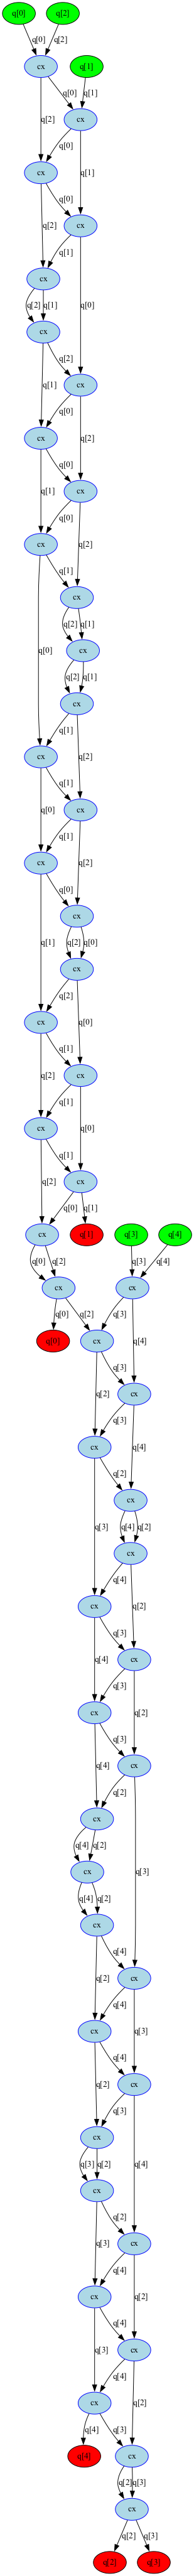

In [60]:
qaoa_dag = qiskit.converters.circuit_to_dag(qaoa)
qaoa_dag.remove_all_ops_named('u1')
qaoa_dag.remove_all_ops_named('u2')
qaoa_dag.remove_all_ops_named('u3')
qaoa_dag.draw()

In [40]:
test_circ = qiskit.QuantumCircuit(5)
for pair in [(0,1), (0,2), (1,2), (2,3), (2,4), (3,4)]:
    test_circ.cx(*pair)
test_circ.draw()

q_0: ──■────■──────────────────────
     ┌─┴─┐  │                      
q_1: ┤ X ├──┼────■─────────────────
     └───┘┌─┴─┐┌─┴─┐               
q_2: ─────┤ X ├┤ X ├──■────■───────
          └───┘└───┘┌─┴─┐  │       
q_3: ───────────────┤ X ├──┼────■──
                    └───┘┌─┴─┐┌─┴─┐
q_4: ────────────────────┤ X ├┤ X ├
                         └───┘└───┘

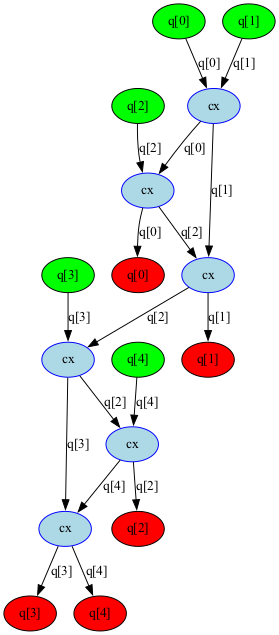

In [67]:
test_dag = qiskit.converters.circuit_to_dag(test_circ)
test_dag.draw()

### Manually specify the cuts
The MIP automatic cut searcher is unable to find the proper cuts for the QDCA circuits.
However, this is why the ansatz is carefully constructed such that the optimal cut locations are already known.
Here, we manually collect the list of 2-qubit operations that appear in each subcircuit and pass these to
the cutting function.

In [119]:
stripped_circ = wire_cutting._circuit_stripping(circuit=qaoa)
print(stripped_circ.count_ops())
stripped_circ.draw(fold=-1)

OrderedDict([('cx', 76)])


┌───┐┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐┌───┐                                                                      ┌───┐┌───┐                                                            ┌───┐┌───┐                                                            
q_0: ┤ X ├┤ X ├┤ X ├┤ X ├──────────┤ X ├┤ X ├┤ X ├┤ X ├─────────────────■─────────■────■────■─────────■─────────■────■────■──┤ X ├┤ X ├──■─────────■──────────────■───────────────────■────────────┤ X ├┤ X ├──■─────────■──────────────■───────────────────■────────────
     └─┬─┘└─┬─┘└─┬─┘└─┬─┘          └─┬─┘└─┬─┘└─┬─┘└─┬─┘          ┌───┐┌─┴─┐┌───┐┌─┴─┐  │    │  ┌───┐┌─┴─┐┌───┐┌─┴─┐  │    │  └─┬─┘└─┬─┘  │         │              │                   │            └─┬─┘└─┬─┘  │         │              │                   │            
q_1: ──┼────■────┼────■────■────■────┼────■────┼────■────■────■──┤ X ├┤ X ├┤ X ├┤ X ├──┼────┼──┤ X ├┤ X ├┤ X ├┤ X ├──┼────┼────■────■────┼────■────┼────■─────────┼─────────■─────────┼─────────■────■────■────┼────■────┼────■─────────┼─────────■─────────┼─────────■──
       │         │       ┌─┴─┐┌─┴─┐  │         │       ┌─┴─┐┌─┴─┐└─┬─┘└───┘└─┬─┘└───┘┌─┴─┐┌─┴─┐└─┬─┘└───┘└─┬─┘└───┘┌─┴─┐┌─┴─┐            │    │    │    │  ┌───┐┌─┴─┐┌───┐┌─┴─┐┌───┐┌─┴─┐┌───┐┌─┴─┐            │    │    │    │  ┌───┐┌─┴─┐┌───┐┌─┴─┐┌───┐┌─┴─┐┌───┐┌─┴─┐
q_2: ──■─────────■───────┤ X ├┤ X ├──■─────────■───────┤ X ├┤ X ├──■─────────■───────┤ X ├┤ X ├──■─────────■───────┤ X ├┤ X ├────────────┼────┼────┼────┼──┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├────────────┼────┼────┼────┼──┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├
                         └───┘└───┘                    └───┘└───┘                    ├───┤├───┤                    ├───┤├───┤          ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐└─┬─┘└───┘└─┬─┘└───┘└─┬─┘└───┘└─┬─┘└───┘          ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐└─┬─┘└───┘└─┬─┘└───┘└─┬─┘└───┘└─┬─┘└───┘
q_3: ───────■─────────■────■────■─────────■─────────■────■────■────■─────────■───────┤ X ├┤ X ├──■─────────■───────┤ X ├┤ X ├──────────┤ X ├┤ X ├┤ X ├┤ X ├──■─────────■─────────■─────────■─────────────────┤ X ├┤ X ├┤ X ├┤ X ├──■─────────■─────────■─────────■───────
     ┌───┐┌─┴─┐┌───┐┌─┴─┐  │    │  ┌───┐┌─┴─┐┌───┐┌─┴─┐  │    │    │         │       └─┬─┘└─┬─┘  │         │       └─┬─┘└─┬─┘          └───┘└───┘└───┘└───┘                                                  └───┘└───┘└───┘└───┘                                        
q_4: ┤ X ├┤ X ├┤ X ├┤ X ├──┼────┼──┤ X ├┤ X ├┤ X ├┤ X ├──┼────┼────┼────■────┼────■────■────■────┼────■────┼────■────■────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     └─┬─┘└───┘└─┬─┘└───┘┌─┴─┐┌─┴─┐└─┬─┘└───┘└─┬─┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐          ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐                                                                                                                                                      
q_5: ──■─────────■───────┤ X ├┤ X ├──■─────────■───────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────────┤ X ├┤ X ├┤ X ├┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                         └───┘└───┘                    └───┘└───┘└───┘└───┘└───┘└───┘          └───┘└───┘└───┘└───┘

In [120]:
_, _, _, id_vertices = wire_cutting._read_circuit(circuit=stripped_circ)
print(id_vertices)

{0: 'q[2]0 q[0]0', 1: 'q[1]0 q[0]1', 2: 'q[2]1 q[0]2', 3: 'q[1]1 q[0]3', 4: 'q[1]2 q[2]2', 5: 'q[1]3 q[2]3', 6: 'q[2]4 q[0]4', 7: 'q[1]4 q[0]5', 8: 'q[2]5 q[0]6', 9: 'q[1]5 q[0]7', 10: 'q[1]6 q[2]6', 11: 'q[1]7 q[2]7', 12: 'q[2]8 q[1]8', 13: 'q[0]8 q[1]9', 14: 'q[2]9 q[1]10', 15: 'q[0]9 q[1]11', 16: 'q[0]10 q[2]10', 17: 'q[0]11 q[2]11', 18: 'q[2]12 q[1]12', 19: 'q[0]12 q[1]13', 20: 'q[2]13 q[1]14', 21: 'q[0]13 q[1]15', 22: 'q[0]14 q[2]14', 23: 'q[0]15 q[2]15', 24: 'q[1]16 q[0]16', 25: 'q[1]17 q[0]17', 26: 'q[5]0 q[4]0', 27: 'q[3]0 q[4]1', 28: 'q[5]1 q[4]2', 29: 'q[3]1 q[4]3', 30: 'q[3]2 q[5]2', 31: 'q[3]3 q[5]3', 32: 'q[5]4 q[4]4', 33: 'q[3]4 q[4]5', 34: 'q[5]5 q[4]6', 35: 'q[3]5 q[4]7', 36: 'q[3]6 q[5]6', 37: 'q[3]7 q[5]7', 38: 'q[3]8 q[5]8', 39: 'q[4]8 q[5]9', 40: 'q[3]9 q[5]10', 41: 'q[4]9 q[5]11', 42: 'q[4]10 q[3]10', 43: 'q[4]11 q[3]11', 44: 'q[3]12 q[5]12', 45: 'q[4]12 q[5]13', 46: 'q[3]13 q[5]14', 47: 'q[4]13 q[5]15', 48: 'q[4]14 q[3]14', 49: 'q[4]15 q[3]15', 50: 'q[0]18 q[3]16'

In [127]:
# The subcircuit qubit information is contained in the subgraph dict
def parse_gate_info(gate_info):
    qubits = []
    for substr in gate_info.split('['):
        if ']' in substr:
            qubits.append(int(substr.split(']')[0]))
    return qubits

print(subgraph_dict)
print(cut_nodes)
qdca_subcircuit_2q_gates = [[] for _ in range(len(subgraphs))]
for vertex_id, gate_info in id_vertices.items():
    for qubit in parse_gate_info(gate_info):
        if qubit not in cut_nodes:
            subcircuit_id = subgraph_dict[qubit]
            break
    qdca_subcircuit_2q_gates[subcircuit_id].append(vertex_id)
print(qdca_subcircuit_2q_gates)

{3: 0, 4: 0, 5: 0, 0: 1, 1: 1, 2: 1}
[2, 3]
[[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]]


### Use the Serverless instance to remotely cut the circuit

In [64]:
with serverless.context():
    cuts_future = cut_circuit_wires_remote(
        circuit=qaoa,
        method="automatic",
        max_subcircuit_width=3,
        max_cuts=1,
        num_subcircuits=[2],
    )
    
    cuts = get(cuts_future)

RayTaskError(DOcplexException): [36mray::cut_circuit_wires_remote()[39m (pid=96628, ip=127.0.0.1)
  File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/quantum_serverless/core/decorators.py", line 200, in wraps
    return func(*args, **kwargs)
  File "/var/folders/yv/jz1jhj4d56v__01vd16xwg0r0000gn/T/ipykernel_66062/1688052512.py", line 13, in cut_circuit_wires_remote
  File "/Users/teague/Workspace/circuit-knitting-toolbox/circuit_knitting_toolbox/circuit_cutting/wire_cutting/wire_cutting.py", line 68, in cut_circuit_wires
    cuts = find_wire_cuts(
  File "/Users/teague/Workspace/circuit-knitting-toolbox/circuit_knitting_toolbox/circuit_cutting/wire_cutting/wire_cutting.py", line 371, in find_wire_cuts
    feasible = mip_model.solve(min_postprocessing_cost=min_cost)
  File "/Users/teague/Workspace/circuit-knitting-toolbox/circuit_knitting_toolbox/circuit_cutting/wire_cutting/mip_model.py", line 513, in solve
    self.objective = self.model.objective_value
  File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/docplex/mp/model.py", line 5371, in objective_value
    self._check_has_solution()
  File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/docplex/mp/model.py", line 5189, in _check_has_solution
    self.fatal("Model<{0}> did not solve successfully", self.name)
  File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/docplex/mp/model.py", line 1080, in fatal
    self._error_handler.fatal(msg, args)
  File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/docplex/mp/error_handler.py", line 210, in fatal
    raise DOcplexException(resolved_message)
docplex.mp.utils.DOcplexException: Model<docplex_cutter> did not solve successfully

In [65]:
cuts

{'max_subcircuit_width': 3,
 'subcircuits': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1774d2320>,
 'complete_path_map': {Qubit(QuantumRegister(5, 'q'), 0): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}],
  Qubit(QuantumRegister(5, 'q'), 1): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 1)}],
  Qubit(QuantumRegister(5, 'q'), 2): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 2)},
   {'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}],
  Qubit(QuantumRegister(5, 'q'), 3): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 1)}],
  Qubit(QuantumRegister(5, 'q'), 4): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 2)}]},
 'num_cuts': 1,
 'counter': {0: {'effective': 2,
   'rho': 0,
   'O': 1,
   'd': 3,
   'depth': 3,
   'size': 3},
  1: {'effective': 3, 'rho': 1, 'O': 0, 'd': 3, 'depth': 3, 'size'

In [52]:
cuts["subcircuits"][0].draw(fold=-1)

q_0: ──■────■───────
     ┌─┴─┐  │       
q_1: ┤ X ├──┼────■──
     └───┘┌─┴─┐┌─┴─┐
q_2: ─────┤ X ├┤ X ├
          └───┘└───┘

In [53]:
cuts["subcircuits"][1].draw(fold=-1)

q_0: ──■────■───────
     ┌─┴─┐  │       
q_1: ┤ X ├──┼────■──
     └───┘┌─┴─┐┌─┴─┐
q_2: ─────┤ X ├┤ X ├
          └───┘└───┘

In [45]:
stripped_circ = wire_cutting._circuit_stripping(circuit=circuit)
_, _, _, id_vertices = wire_cutting._read_circuit(circuit=stripped_circ)

# The subcircuit qubit information is contained in the subgraph dict
def parse_gate_info(gate_info):
    qubits = []
    for substr in gate_info.split('['):
        if ']' in substr:
            qubits.append(int(substr.split(']')[0]))
    return qubits

# Hardcoded to 2 subcircuits only 
qdca_subcircuit_2q_gates = [[], []]
for vertex_id, gate_info in id_vertices.items():
    for qubit in parse_gate_info(gate_info):
        if qubit not in cut_nodes:
            subcircuit_id = subgraph_dict[qubit]
            break
    qdca_subcircuit_2q_gates[subcircuit_id].append(vertex_id)

In [46]:
with serverless.context():
    cuts_future = cut_circuit_wires_remote(
        circuit=circuit,
        method="manual",
        subcircuit_vertices=qdca_subcircuit_2q_gates,
    )
    
    man_cuts = get(cuts_future)

RayTaskError(AssertionError): [36mray::cut_circuit_wires_remote()[39m (pid=57400, ip=127.0.0.1)
  File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/quantum_serverless/core/decorators.py", line 200, in wraps
    return func(*args, **kwargs)
  File "/var/folders/yv/jz1jhj4d56v__01vd16xwg0r0000gn/T/ipykernel_10672/2998168334.py", line 122, in cut_circuit_wires_remote
  File "/Users/teague/Workspace/circuit-knitting-toolbox/circuit_knitting_toolbox/circuit_cutting/wire_cutting/wire_cutting.py", line 82, in cut_circuit_wires
    cuts = cut_circuit_wire(
  File "/Users/teague/Workspace/circuit-knitting-toolbox/circuit_knitting_toolbox/circuit_cutting/wire_cutting/wire_cutting.py", line 454, in cut_circuit_wire
    subcircuit_object = _subcircuits_parser(
  File "/Users/teague/Workspace/circuit-knitting-toolbox/circuit_knitting_toolbox/circuit_cutting/wire_cutting/wire_cutting.py", line 697, in _subcircuits_parser
    assert nearest_subcircuit_idx != -1
AssertionError

In [130]:
man_cuts

{'max_subcircuit_width': 4,
 'subcircuits': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x177cd1930>,
 'complete_path_map': {Qubit(QuantumRegister(6, 'q'), 0): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 0)}],
  Qubit(QuantumRegister(6, 'q'), 1): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 1)}],
  Qubit(QuantumRegister(6, 'q'), 2): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 2)}],
  Qubit(QuantumRegister(6, 'q'), 3): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)},
   {'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 3)}],
  Qubit(QuantumRegister(6, 'q'), 4): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 1)}],
  Qubit(QuantumRegister(6, 'q'), 5): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 2)}]},
 'num_cuts': 1,
 'counter': {0: {'effective': 2,
   'rho': 

In [131]:
man_cuts["subcircuits"][0].draw(fold=-1)

┌───────────┐                                                                                               ┌─────────┐                                                                                                      ┌─────────┐                  ┌───────────┐┌───────────┐                                                              ┌─────────┐         ┌───┐   ┌──────────┐    ┌───┐                                                      ┌─────────┐         ┌───┐   ┌──────────┐   ┌───┐    ┌───────────┐┌───────────┐
q_0: ┤ U3(π,0,π) ├───────────────────────────────────────────■────────────────────────────────■───────────────■──┤ U1(π/4) ├─────────────────■────────────────────────────────■────────────────────────────────■───────────────■──┤ U1(π/4) ├───────────────■──┤ U3(π,0,π) ├┤ U3(π,0,π) ├──────────────────────────■────────────────────────────────■──┤ U1(π/4) ├─────────┤ X ├───┤ U1(-π/4) ├────┤ X ├──────────────────■────────────────────────────────■──┤ U1(π/4) ├─────────┤ X ├───┤ U1(-π/4) ├───┤ X ├────┤ U3(π,0,π) ├┤ U3(π,0,π) ├
     └┬─────────┬┘┌───────────┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  ├─────────┤ ┌────────────┐  │  ┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  ├─────────┤ ┌──────────┐  │  ├───────────┤└───────────┘                          │                                │  └─────────┘         └─┬─┘   ├─────────┬┘    └─┬─┘                  │                                │  └─────────┘         └─┬─┘   ├─────────┬┘   └─┬─┘    ├───────────┤└─┬───────┬─┘
q_1: ─┤ U1(π/2) ├─┤ U3(2,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├──┼──┤ U2(0,π) ├─┤ U3(-2,0,0) ├──┼──┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├──┼──┤ U2(0,π) ├─┤ U1(-π/2) ├──┼──┤ U3(π,0,π) ├───────────────────────────────────────┼────────────────■───────────────┼────────────────■───────■─────┤ U1(π/4) ├───────■────────────────────┼────────────────■───────────────┼────────────────■───────■─────┤ U1(π/4) ├──────■──────┤ U3(π,0,π) ├──┤ U1(2) ├──
     ┌┴─────────┴┐└───────────┘└─────────┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐├─────────┴┐└────────────┘┌─┴─┐└─────────┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐├─────────┴┐└──────────┘┌─┴─┐├───────────┤ ┌─────────┐ ┌───────────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐├─────────┤ ┌────────────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐├─────────┤ ┌──────────┐└─┬───────┬─┘  └───────┘  
q_2: ┤ U3(π,0,π) ├──────────────────────────■────────────────────────────────■──┤ U1(π/4) ├─────────────────┤ X ├┤ U1(-π/4) ├──────────────┤ X ├─────────────■────────────────────────────────■──┤ U1(π/4) ├─────────────────┤ X ├┤ U1(-π/4) ├────────────┤ X ├┤ U3(π,0,π) ├─┤ U1(π/2) ├─┤ U3(3,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U3(-3,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U1(-π/2) ├──┤ U1(2) ├───────────────
     └───────────┘                                                              └─────────┘                 └───┘└──────────┘              └───┘                                                 └─────────┘                 └───┘└──────────┘            └───┘└───────────┘ └─────────┘ └───────────┘└─────────┘└───┘└──────────┘└───┘└─────────┘└───┘└──────────┘└───┘└─────────┘└─────────┘ └────────────┘└─────────┘└───┘└──────────┘└───┘└─────────┘└───┘└──────────┘└───┘└─────────┘└─────────┘ └──────────┘  └───────┘

In [132]:
man_cuts["subcircuits"][1].draw(fold=-1)

┌─────────┐  ┌───────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌─────────┐ ┌────────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌─────────┐ ┌──────────┐┌───────────┐                                                                                                            ┌─────────┐                                                                                                      ┌─────────┐                  ┌───────────┐ ┌───────────┐ ┌─────────────┐   ┌───┐   ┌──────────────┐┌───┐                                                                                                                                                                               ┌─────────────┐                                             ┌───┐     ┌──────────────┐     ┌───┐                                                                                                                                                                                     ┌───────────┐ ┌───────┐                                                           
q_0: ──┤ U1(π/2) ├──┤ U3(4,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U3(-4,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U1(-π/2) ├┤ U3(π,0,π) ├────────────────────────────────────────────────────────■────────────────────────────────■───────────────■──┤ U1(π/4) ├─────────────────■────────────────────────────────■────────────────────────────────■───────────────■──┤ U1(π/4) ├───────────────■──┤ U3(π,0,π) ├─┤ U3(π,0,π) ├─┤ U3(0,0,π/8) ├───┤ X ├───┤ U3(0,0,-π/8) ├┤ X ├──■────────────────────────────────────────■──────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────■──┤ U3(0,0,π/8) ├─────────────────────────────────────────────┤ X ├─────┤ U3(0,0,-π/8) ├─────┤ X ├───────■────────────────────────────────────────■──────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────■───┤ U3(π,0,π) ├─┤ U1(2) ├───────────────────────────────────────────────────────────
      ┌┴─────────┴┐ └───────────┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘├─────────┤ └────────────┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘├─────────┤ └──────────┘├───────────┤ ┌─────────┐ ┌───────────┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  ├─────────┤ ┌────────────┐  │  ┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  ├─────────┤ ┌──────────┐  │  ├───────────┤┌┴───────────┴┐└─────────────┘   └─┬─┘   └──────────────┘└─┬─┘  │                                        │                                              │                                                                                 │  └─────────────┘                          ┌─────────────┐    └─┬─┘     └──────────────┘     └─┬─┘       │                                        │                                              │                                                                                 │   └───────────┘ └───────┘                         ┌───────────┐ ┌───────┐           
q_1: ─┤ U3(π,0,π) ├───────────────────────────┼────────────────■───────────────┼────────────────■───────■─────┤ U1(π/4) ├───────■────────────────────┼────────────────■───────────────┼────────────────■───────■─────┤ U1(π/4) ├──────■──────┤ U3(π,0,π) ├─┤ U1(π/2) ├─┤ U3(5,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├──┼──┤ U2(0,π) ├─┤ U3(-5,0,0) ├──┼──┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├──┼──┤ U2(0,π) ├─┤ U1(-π/2) ├──┼──┤ U3(π,0,π) ├┤ U3(0,0,π/8) ├────────────────────■───────────────────────■────┼────────────────────■───────────────────┼────────────────────■─────────────────────────┼───────────

## Step 4: Evaluate the subcircuits remotely

In [160]:
options = Options(execution={"shots":100})
backend_names = ["ibmq_qasm_simulator"] * 2

In [161]:
with serverless.context():
    service_args = service.active_account()
    
    options_dict = asdict(options)
    
    subcircuit_probabilities_future = evaluate_subcircuits_remote(
        man_cuts,
        service_args=service_args,
        backend_names=backend_names,
        options_dict=options_dict,
    )
    
    subcircuit_instance_probabilities = get(subcircuit_probabilities_future)

## Step 5: Reconstruct the output remotely

In [163]:
with serverless.context():
    reconstructed_probabilities_future = reconstruct_full_distribution_remote(
        qaoa,
        subcircuit_instance_probabilities,
        man_cuts,
    )
    
    reconstructed_probabilities = get(reconstructed_probabilities_future)

(reconstruct_full_distribution_remote pid=43390) Exception ignored in atexit callback: <function reset_all at 0x10c0d2830>
(reconstruct_full_distribution_remote pid=43390) Traceback (most recent call last):
(reconstruct_full_distribution_remote pid=43390)   File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/ray/thirdparty_files/colorama/initialise.py", line 32, in reset_all
(reconstruct_full_distribution_remote pid=43390)     def reset_all():
(reconstruct_full_distribution_remote pid=43390)   File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/ray/_private/worker.py", line 1655, in sigterm_handler
(reconstruct_full_distribution_remote pid=43390)     sys.exit(signum)
(reconstruct_full_distribution_remote pid=43390) SystemExit: 15


### Verify the output

In [164]:
metrics, exact_probabilities = verify(qaoa, reconstructed_probabilities)

In [165]:
metrics

{'nearest': {'chi2': 0.03247881590382722,
  'Mean Squared Error': 0.00022190387049795995,
  'Mean Absolute Percentage Error': 99414062500008.45,
  'Cross Entropy': 1.3758700021695554,
  'HOP': 0.9964624999999999},
 'naive': {'chi2': 0.03310678276758181,
  'Mean Squared Error': 0.0002134907155564947,
  'Mean Absolute Percentage Error': 136469654111464.84,
  'Cross Entropy': 1.3749983578425822,
  'HOP': 0.9951863431095231}}

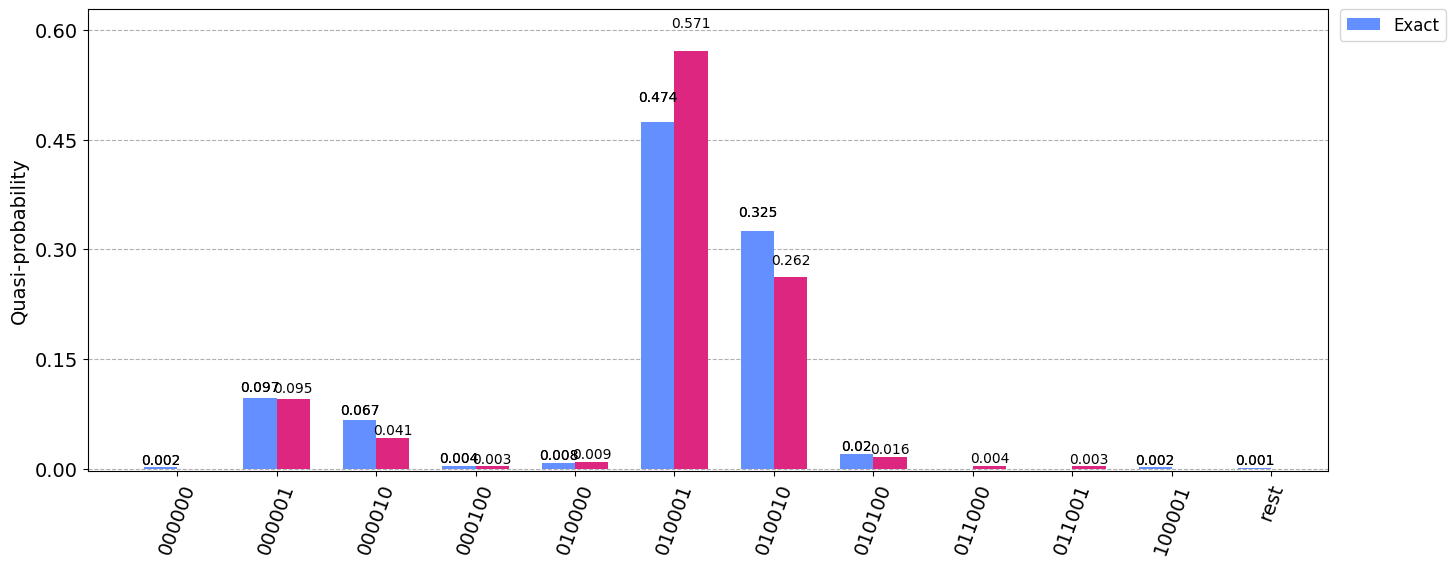

In [166]:
# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)

reconstructed_dict_bitstring = qiskit.result.ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=len(qaoa.qubits))


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = qiskit.result.ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=len(qaoa.qubits)
)

# plot a histogram of the distributions
qiskit.visualization.plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=9,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

## Put it all together

### Testing

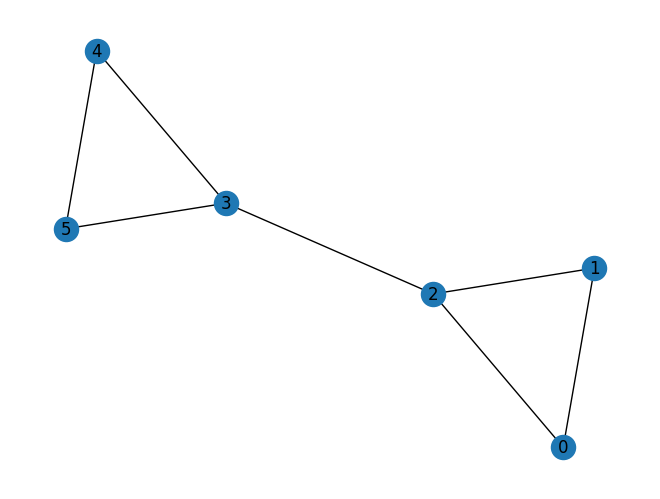

In [7]:
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (0,2), (2,3), (3,4), (4,5), (3,5)])
nx.draw_spring(G, with_labels=True)

In [9]:
max_cuts = 1
params = [i+1 for i in range(5)] + [1]

circuit, subgraph_dict, cut_nodes, hot_nodes, active_mixers = get_circuit_from_graph(
    G,
    max_cuts,
    params,
    barriers=0,
    decompose_level=2
)
print(subgraph_dict)
print(cut_nodes)
print(hot_nodes)
circuit.draw(fold=-1)

{3: 0, 4: 0, 5: 0, 0: 1, 1: 1, 2: 1}
[2, 3]
[3]


global phase: 0.28319
      ┌─────────┐  ┌───────────┐ ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ┌───┐    ┌──────────┐   ┌───┐   ┌─────────┐   ┌───┐    ┌──────────┐   ┌───┐   ┌─────────┐┌─────────┐ ┌────────────┐┌─────────┐   ┌───┐   ┌──────────┐   ┌───┐    ┌─────────┐   ┌───┐   ┌──────────┐   ┌───┐    ┌─────────┐┌─────────┐ ┌──────────┐┌───────────┐                                                                                                                                                 ┌─────────┐                                                                                                                                                ┌─────────┐                          ┌───────────┐┌───────┐
q_0: ─┤ U1(π/2) ├──┤ U3(5,0,0) ├─┤ U2(0,π) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├────┤ U1(-π/4) ├───┤ X ├───┤ U1(π/4) ├───┤ X ├────┤ U1(-π/4) ├───┤ X ├───┤ U1(π/4) ├┤ U2(0,π) ├─┤ U3(-5,0,0) ├┤ U2(0,π) ├───┤ X ├───┤ U1(-π/4) ├───┤ X ├────┤ U1(π/4) ├───┤ X ├───┤ U1(-π/4) ├───┤ X ├────┤ U1(π/4) ├┤ U2(0,π) ├─┤ U1(-π/2) ├┤ U3(π,0,π) ├──────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────■─────────────────────■──────┤ U1(π/4) ├────────────────────■────────────────────────────────────────────────■─────────────────────────────────────────────■──────────────────────■─────┤ U1(π/4) ├───────────────────■──────┤ U3(π,0,π) ├┤ U1(2) ├
     ┌┴─────────┴┐ └───────────┘ └─────────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              └─┬─┘    └──────────┘   └─┬─┘   └─────────┘   └─┬─┘    └──────────┘   └─┬─┘   └─────────┘├─────────┤ └────────────┘└─────────┘   └─┬─┘   └──────────┘   └─┬─┘    └─────────┘   └─┬─┘   └──────────┘   └─┬─┘    └─────────┘├─────────┤ └──────────┘├───────────┤ ┌─────────┐ ┌───────────┐ ┌─────────┐     ┌───┐     ┌──────────┐   ┌─┴─┐   ┌─────────┐   ┌───┐    ┌──────────┐   ┌─┴─┐   ┌─────────┐     │      ├─────────┤ ┌────────────┐     │       ┌─────────┐     ┌───┐   ┌──────────┐   ┌─┴─┐    ┌─────────┐   ┌───┐   ┌──────────┐   ┌─┴─┐    ┌─────────┐     │     ├─────────┤ ┌──────────┐      │      └─┬───────┬─┘└───────┘
q_1: ┤ U3(π,0,π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [21]:
sim_options = SimulatorOptions(
    noise_model=get_pauli_noise_func(),
    basis_gates=['u1', 'u2', 'u3', 'cx'],
)
options = Options(execution={"shots":2000}, simulator=sim_options)
backend_names = ["ibmq_qasm_simulator"] * 2
reconstructed_probabilities, cuts = remote_cut_sim_reconstruct(
    circuit,
    subgraph_dict,
    cut_nodes,
    options,
    backend_names,
    serverless,
    service,
)

(cut_circuit_wires_remote pid=95466) --------------------
(cut_circuit_wires_remote pid=95466) subcircuit 0
(cut_circuit_wires_remote pid=95466) ρ qubits = 0, O qubits = 1, width = 4, effective = 3, depth = 102, size = 151
(cut_circuit_wires_remote pid=95466)      ┌───────────┐┌─────────────┐                                          »
(cut_circuit_wires_remote pid=95466) q_0: ┤ U3(π,0,π) ├┤ U3(0,0,π/8) ├─────────────■────────────────────■───────»
(cut_circuit_wires_remote pid=95466)      └┬─────────┬┘└┬───────────┬┘┌─────────┐  │  ┌─────────────┐   │       »
(cut_circuit_wires_remote pid=95466) q_1: ─┤ U1(π/2) ├──┤ U3(2,0,0) ├─┤ U2(0,π) ├──┼──┤ U3(0,0,π/8) ├───┼───────»
(cut_circuit_wires_remote pid=95466)      ┌┴─────────┴┐┌┴───────────┴┐└─────────┘┌─┴─┐├─────────────┴┐┌─┴─┐     »
(cut_circuit_wires_remote pid=95466) q_2: ┤ U3(π,0,π) ├┤ U3(0,0,π/8) ├───────────┤ X ├┤ U3(0,0,-π/8) ├┤ X ├──■──»
(cut_circuit_wires_remote pid=95466)      ├───────────┤├─────────────┤           └───┘└──────

(reconstruct_full_distribution_remote pid=95466) Exception ignored in: <module 'threading' from '/usr/local/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py'>
(reconstruct_full_distribution_remote pid=95466) Traceback (most recent call last):
(reconstruct_full_distribution_remote pid=95466)   File "/usr/local/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1518, in _shutdown
(reconstruct_full_distribution_remote pid=95466)     def _shutdown():
(reconstruct_full_distribution_remote pid=95466)   File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/ray/_private/worker.py", line 1655, in sigterm_handler
(reconstruct_full_distribution_remote pid=95466)     sys.exit(signum)
(reconstruct_full_distribution_remote pid=95466) SystemExit: 15


In [22]:
cuts

{'max_subcircuit_width': 4,
 'subcircuits': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1752032e0>,
 'complete_path_map': {Qubit(QuantumRegister(6, 'q'), 0): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}],
  Qubit(QuantumRegister(6, 'q'), 1): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 1)}],
  Qubit(QuantumRegister(6, 'q'), 2): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 0)},
   {'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 2)}],
  Qubit(QuantumRegister(6, 'q'), 3): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 1)}],
  Qubit(QuantumRegister(6, 'q'), 4): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 2)}],
  Qubit(QuantumRegister(6, 'q'), 5): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 3)}]},
 'num_cuts': 1,
 'counter': {0: {'effective': 3,
   'rho': 

In [23]:
cuts['subcircuits'][0].draw(fold=-1)

┌───────────┐┌─────────────┐                                                                                                                                                                                                                                                             ┌─────────────┐                                                                                                                                                                                                                                                                                               ┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
q_0: ┤ U3(π,0,π) ├┤ U3(0,0,π/8) ├─────────────■────────────────────■─────────────────────────■────────────────────────────────────────■──────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────■──┤ U3(0,0,π/8) ├──■──────────────────────────────────────────────■─────────────────────────■────────────────────────────────────────■──────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────────■──────┤ U3(π,0,π) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     └┬─────────┬┘└┬───────────┬┘┌─────────┐  │  ┌─────────────┐   │                         │                                        │  ┌───┐┌──────────────┐┌───┐┌─────────────┐┌───┐┌──────────────┐┌─┴─┐┌─────────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐┌───┐┌──────────────┐┌─┴─┐└─┬─────────┬─┘  │   ┌────────────┐ ┌─────────┐┌─────────────┐  │                         │                                        │  ┌───┐┌──────────────┐┌───┐┌─────────────┐┌───┐┌──────────────┐┌─┴─┐┌─────────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐           ┌───┐┌──────────────┐    ┌─┴─┐    └┬─────────┬┘┌──────────┐┌───────────┐                                                      ┌─────────┐                                                                                                      ┌─────────┐                  ┌───────────┐┌───────────┐                                                              ┌─────────┐         ┌───┐   ┌──────────┐    ┌───┐                                                      ┌─────────┐         ┌───┐   ┌──────────┐   ┌───┐    ┌───────────┐┌───────┐
q_1: ─┤ U1(π/2) ├──┤ U3(2,0,0) ├─┤ U2(0,π) ├──┼──┤ U3(0,0,π/8) ├───┼─────────────────────────┼────────────────────────────────────────┼──┤ X ├┤ U3(0,0,-π/8) ├┤ X ├┤ U3(0,0,π/8) ├┤ X ├┤ U3(0,0,-π/8) ├┤ X ├┤ U3(0,0,π/8) ├┤ X ├┤ U3(0,0,-π/8) ├┤ X ├┤ U3(0,0,π/8) ├┤ X ├┤ U3(0,0,-π/8) ├┤ X ├──┤ U2(0,π) ├────┼───┤ U3(-2,0,0) ├─┤ U2(0,π) ├┤ U3(0,0,π/8) ├──┼─────────────────────────┼────────────────────────────────────────┼──┤ X ├┤ U3(0,0,-π/8) ├┤ X ├┤ U3(0,0,π/8) ├┤ X ├┤ U3(0,0,-π/8) ├┤ X ├┤ U3(0,0,π/8) ├┤ X ├┤ U3(0,0,-π/8) ├┤ X ├┤ U3(0,0,π/8) ├───────────┤ X ├┤ U3(0,0,-π/8) ├────┤ X ├─────┤ U2(0,π) ├─┤ U1(-π/2) ├┤ U3(π,0,π) ├──■────────────────────────────────■───────────────■──┤ U1(π/4) ├─────────────────■────────────────────────────────

In [24]:
cuts['subcircuits'][1].draw(fold=-1)

┌─────────┐ ┌───────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌─────────┐ ┌────────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌─────────┐ ┌──────────┐┌───────────┐                                                                                                            ┌─────────┐                                                                                                      ┌─────────┐                  ┌───────────┐┌───────┐
q_0: ─┤ U1(π/2) ├─┤ U3(5,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U3(-5,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U1(-π/2) ├┤ U3(π,0,π) ├────────────────────────────────────────────────────────■────────────────────────────────■───────────────■──┤ U1(π/4) ├─────────────────■────────────────────────────────■────────────────────────────────■───────────────■──┤ U1(π/4) ├───────────────■──┤ U3(π,0,π) ├┤ U1(2) ├
     ┌┴─────────┴┐└───────────┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘├─────────┤ └────────────┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘├─────────┤ └──────────┘├───────────┤ ┌─────────┐ ┌───────────┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  ├─────────┤ ┌────────────┐  │  ┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  ├─────────┤ ┌──────────┐  │  └─┬───────┬─┘└───────┘
q_1: ┤ U3(π,0,π) ├──────────────────────────┼────────────────■───────────────┼────────────────■───────■─────┤ U1(π/4) ├───────■────────────────────┼────────────────■───────────────┼────────────────■───────■─────┤ U1(π/4) ├──────■──────┤ U3(π,0,π) ├─┤ U1(π/2) ├─┤ U3(1,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├──┼──┤ U2(0,π) ├─┤ U3(-1,0,0) ├──┼──┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├──┼──┤ U2(0,π) ├─┤ U1(-π/2) ├──┼────┤ U1(2) ├───────────
     ├───────────┤                          │                                │  ┌─────────┐         ┌─┴─┐   ├─────────┴┐    ┌─┴─┐                  │                                │  ┌─────────┐         ┌─┴─┐   ├─────────┴┐   ┌─┴─┐    ├───────────┤┌┴─────────┴┐└───────────┘└─────────┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐├─────────┴┐└────────────┘┌─┴─┐└─────────┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐├─────────┴┐└──────────┘┌─┴─┐┌─┴───────┴─┐┌───────┐
q_2: ┤ U3(π,0,π) ├──────────────────────────■────────────────────────────────■──┤ U1(π/4) ├─────────┤ X ├───┤ U1(-π/4) ├────┤ X ├──────────────────■────────────────────────────────■──┤ U1(π/4) ├─────────┤ X ├───┤ U1(-π/4) ├───┤ X ├────┤ U3(π,0,π) ├┤ U3(π,0,π) ├──────────────────────────■────────────────────────────────■──┤ U1(π/4) ├─────────────────┤ X ├┤ U1(-π/4) ├──────────────┤ X ├─────────────■────────────────────────────────■──┤ U1(π/4) ├─────────────────┤ X ├┤ U1(-π/4) ├────────────┤ X ├┤ U3(π,0,π) ├┤ U1(2) ├
     └───────────┘                                                              └─────────┘         └───┘   └──────────┘    └───┘                                                      └─────────┘         └───┘   └──────────┘   └───┘    └───────────┘└───────────┘                                                              └─────────┘                 └───┘└──────────┘              └───┘                                                 └─────────┘                 └───┘└──────────┘            └───┘└───────────┘└───────┘

In [25]:
metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

In [26]:
metrics

{'nearest': {'chi2': 0.5709549977431122,
  'Mean Squared Error': 0.0030217078434320445,
  'Mean Absolute Percentage Error': 5492675781250127.0,
  'Cross Entropy': 1.5231503209504598,
  'HOP': 0.9188788749999998},
 'naive': {'chi2': 0.5709549977431122,
  'Mean Squared Error': 0.0030217078434320445,
  'Mean Absolute Percentage Error': 5492675781250127.0,
  'Cross Entropy': 1.5231503209504598,
  'HOP': 0.9188788749999998}}

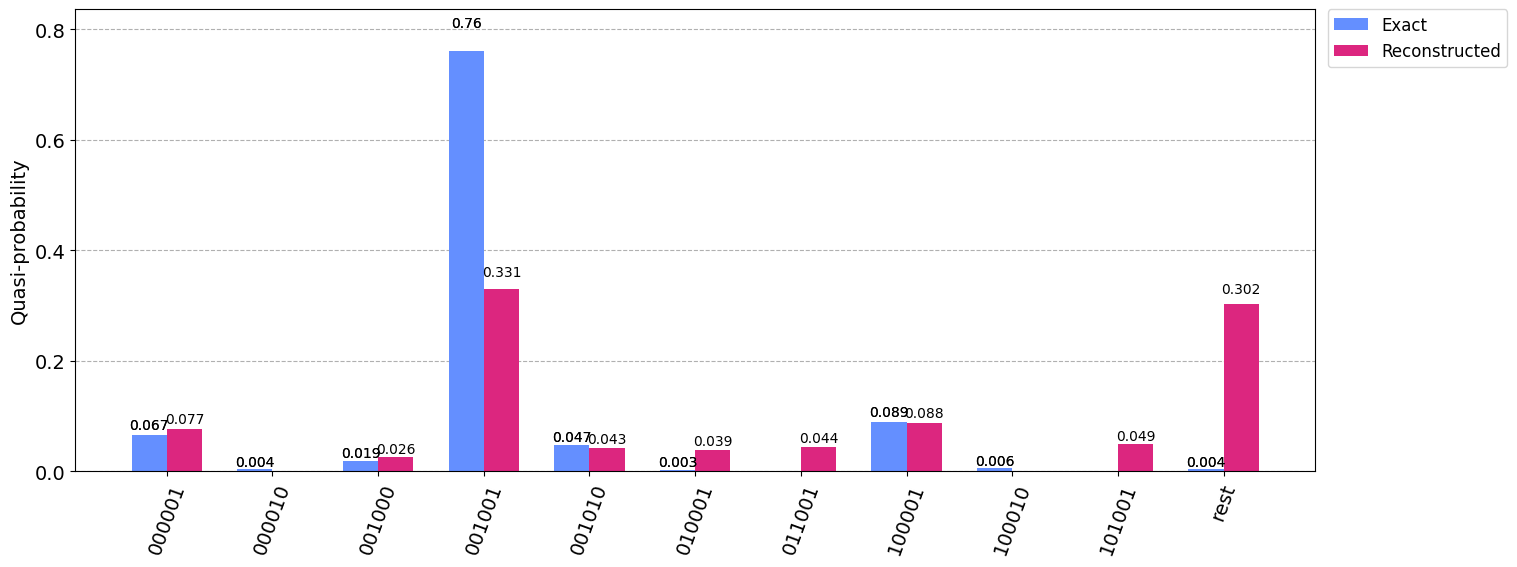

In [27]:
# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)

reconstructed_dict_bitstring = qiskit.result.ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=len(circuit.qubits))


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = qiskit.result.ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=len(circuit.qubits)
)

# plot a histogram of the distributions
qiskit.visualization.plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

## Evaluation

In [8]:
service = QiskitRuntimeService(channel="ibm_cloud")
print(service.backends())
print(service.programs())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]
[<RuntimeProgram('hello-world-89yvgl6jG5')>, <RuntimeProgram('hello-world')>, <RuntimeProgram('sampler')>, <RuntimeProgram('estimator')>]


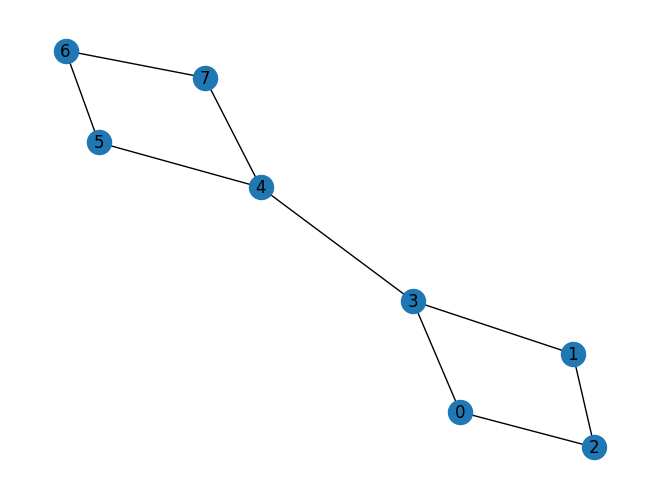

In [144]:
#G = nx.Graph()
#G.add_edges_from([(0,1), (1,2), (0,2), (2,3), (3,4), (4,5), (3,5)])
#target_graph = (
#    "/Users/teague/Workspace/dqva-and-circuit-cutting/"
#    "benchmark_graphs/N18_com2_pin20_pout2_graphs/G10.txt"
#)
#G = qcopt.graph_funcs.graph_from_file(target_graph)
target_graph = '8-node_custom_barbell'
G = nx.Graph()
#G.add_edges_from([(0,1), (1,2), (0,2), (2,3), (3,4), (4,5), (3,5)])
G.add_edges_from([(0,2), (1,2), (1,3), (0,3), (3,4), (4,5), (5,6), (6,7), (4,7)])
nx.draw_spring(G, with_labels=True)

In [146]:
max_cuts = 1
params = None

circuit, subgraph_dict, cut_nodes, hot_nodes, active_mixers = runtime_helpers.get_circuit_from_graph(
    G,
    max_cuts,
    params,
    barriers=0,
    decompose_level=1
)
print(subgraph_dict)
print(active_mixers)
print(cut_nodes)
print(hot_nodes)
print(circuit.count_ops())
circuit = qiskit.compiler.transpile(circuit, optimization_level=3)
print(circuit.count_ops())
circuit.draw(fold=-1)

{4: 0, 5: 0, 6: 0, 7: 0, 0: 1, 1: 1, 2: 1, 3: 1}
[5, 6, 7, 0, 1, 2, 4]
[3, 4]
[4]
OrderedDict([('x', 30), ('rz', 22), ('ry', 14), ('ccx', 12), ('mcx', 2)])
OrderedDict([('cx', 100), ('tdg', 36), ('p', 24), ('u3', 22), ('t', 22), ('rz', 17), ('ry', 14), ('h', 13), ('x', 8)])


global phase: π/4
          ┌─────────┐      ┌─────────────┐┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌───┐      ┌─────┐┌───┐┌───┐ ┌───┐ ┌─────┐       ┌───┐       ┌─────────────────┐┌──────────────┐┌───┐┌───┐┌─────┐ ┌───┐ ┌───┐┌───┐┌─────┐ ┌───┐ ┌─────────────────┐                                                                                                                                                                                                                                                                                                                                                                              ┌─────────┐                                                                                                                        ┌───┐┌───────────────┐                                                                                   
q_0: ─────┤ Rz(π/2) ├──────┤ Ry(theta_5) ├┤ H ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├──────┤ Tdg ├┤ X ├┤ T ├─┤ X ├─┤ Tdg ├───────┤ X ├───────┤ U3(π/2,0,-3π/4) ├┤ Ry(-theta_5) ├┤ H ├┤ X ├┤ Tdg ├─┤ X ├─┤ T ├┤ X ├┤ Tdg ├─┤ X ├─┤ U3(π/2,π/2,π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────■─────────────────■───────────┤ Rz(π/2) ├──────■─────────────────■────────────────────────────────────────■──────────────────■───────────────────────────────■───┤ X ├┤ Rz(2*theta_0) ├───────────────────────────────────────────────────────────────────────────────────
          ├─────────┤      ├─────────────┤├───┤                                                                                                                                                                                                                                                                                                                                                                                                                                                        └─┬─┘      └─────┘└─┬─┘└───┘ └─┬─┘ └─────┘       └─┬─┘       └─────────────────┘└──────────────┘└───┘└─┬─┘└─────┘ └─┬─┘ └───┘└─┬─┘└─────┘ └─┬─┘ └─────────────────┘                         ┌───┐ ┌─────┐      ┌───┐            ┌───┐     ┌───┐┌─────┐ ┌───┐ ┌─────────────────┐┌──────────────┐┌───┐ ┌───┐ ┌─────┐       ┌───┐       ┌───┐     ┌───┐      ┌─────┐┌───┐┌─────────────────┐                                                                                │                    ┌───┐               │               ┌─┴─┐         └─┬─────┬─┘    ┌─┴─┐               │                     ┌───┐              │                ┌─┴─┐              ┌─────┐      ┌─┴─┐ ├───┤├───────────────┤                                                                                   
q_1: ─────┤ Rz(π/2) ├──────┤ Ry(theta_6) ├┤ H ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

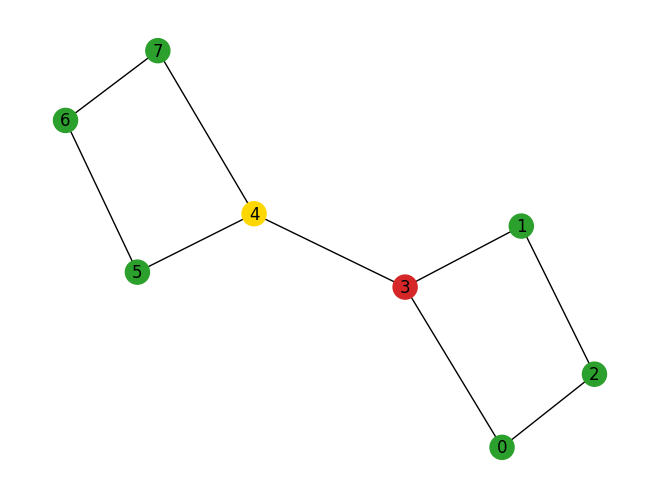

In [53]:
node_color = ['tab:green' if node in active_mixers else 'tab:red' for node in sorted(G.nodes)]
for node in hot_nodes:
    node_color[node] = 'gold'
nx.draw_spring(G, with_labels=True, node_color=[node_color[node] for node in G.nodes])

### Get optimal angles

In [54]:
out = runtime_helpers.optimize_circuit(circuit)
print(out)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9999995000000004
       x: [ 1.583e+00  1.571e+00  4.712e+00  4.031e+00 -2.546e-05
            1.571e+00  3.776e+00  1.571e+00]
    nfev: 125
   maxcv: 0.0


In [55]:
out.x

array([ 1.58329344e+00,  1.57094103e+00,  4.71213388e+00,  4.03133893e+00,
       -2.54560073e-05,  1.57121982e+00,  3.77568830e+00,  1.57128129e+00])

In [56]:
params = out.x
circuit = circuit.bind_parameters(out.x)

### Noiseless simulation

In [57]:
temp_circuit = copy.deepcopy(circuit)
temp_circuit.measure_all()
with Session(service, backend="ibmq_qasm_simulator") as session:
    sampler = Sampler(session=session)

    job = sampler.run(temp_circuit, shots=4000)
    print(f"Job ID: {job.job_id()}")
    print(f"Job result: {job.result()}")
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: cgh0eocqev5v8om36ls0
Job result: SamplerResult(quasi_dists=[{163: 1.0}], metadata=[{'header_metadata': {}, 'shots': 4000}])


In [58]:
full_ideal_sim_job = service.job('cgh0eocqev5v8om36ls0')
full_ideal_sim_result = full_ideal_sim_job.result()
full_ideal_prob_dist = full_ideal_sim_result.quasi_dists[0].nearest_probability_distribution()
full_ideal_sim_shots = full_ideal_sim_result.experiments[0]['metadata']['shots']

In [59]:
full_ideal_sim_job.logs()

'2023-03-27T14:54:53.925496035-05:00 Setting up watches.\n2023-03-27T14:54:53.925496035-05:00 Watches established.\n2023-03-27T14:54:56.298812715-05:00 INFO:     Started server process [8]\n2023-03-27T14:54:56.298926359-05:00 INFO:     Waiting for application startup.\n2023-03-27T14:54:56.299187761-05:00 INFO:     Application startup complete.\n2023-03-27T14:54:56.300317180-05:00 INFO:     Uvicorn running on http://127.0.0.1:8081 (Press CTRL+C to quit)\n2023-03-27T16:15:13.246382685-05:00 INFO:     127.0.0.1:47628 - "POST /run HTTP/1.1" 202 Accepted\n2023-03-27T16:15:13.960805114-05:00 program - WARNING Backend (qasm_simulator) does not support dynamical decoupling.\n2023-03-27T16:15:14.365360743-05:00 /pod-data/ CLOSE_WRITE,CLOSE terminated\n2023-03-27T16:15:14.365814442-05:00 Termination marker file found. Kill process (8).\n2023-03-27T16:15:14.394691442-05:00 /bin/bash: line 3:     8 Killed                  python -m uvicorn server.main:app --port 8081\n2023-03-27T16:15:14.395375763

In [60]:
full_ideal_sim_shots

4000

In [61]:
# save results
with open(f'QCE2023/runtime_results/QDCA-8qubit-results/ideal-sim_fullcirc_{full_ideal_sim_shots}-shots_03-27-2023.pickle', 'wb') as pklfile:
    data_dict = {
        'graphfile': target_graph,
        'G': G,
        'params': params,
        'circuit': circuit,
        'job_id':full_ideal_sim_job.job_id(),
        'job_result':full_ideal_sim_job.result(),
        'nearest_distribution':full_ideal_prob_dist,
        'full_dist':full_ideal_prob_dist.binary_probabilities(num_bits=circuit.num_qubits)
    }
    pickle.dump(data_dict, pklfile)

In [62]:
backend_names = ["ibmq_qasm_simulator"] * 2
ideal_sim_metrics = {}

for shots in [2000]:
    ideal_options = Options(execution={"shots":shots})

    reconstructed_probabilities, cuts = remote_runtime.local_cut_sim_reconstruct(
        circuit,
        subgraph_dict,
        cut_nodes,
        ideal_options,
        backend_names,
        service,
        num_threads=2,
    )

    metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

    ideal_sim_metrics[shots] = metrics
    
    temp_dist = {i: prob for i, prob in enumerate(reconstructed_probabilities)}
    recon_dist = qiskit.result.ProbDistribution(data=temp_dist).binary_probabilities(num_bits=circuit.num_qubits)    

    # save results
    with open(f'QCE2023/runtime_results/QDCA-8qubit-results/ideal-sim_{max_cuts}cuts_{shots}-shots_03-27-2023.pickle', 'wb') as pklfile:
        data_dict = {
            'graphfile': target_graph,
            'G': G,
            'max_cuts': max_cuts,
            'params': params,
            'circuit': circuit,
            'subgraph_dict': subgraph_dict,
            'cut_nodes': cut_nodes,
            'hot_nodes': hot_nodes,
            'active_mixers': active_mixers,
            'noise_model': None,
            'reconstructed_probs': reconstructed_probabilities,
            'cuts': cuts,
            'metrics': metrics,
            'exact_probs': exact_probabilities,
            'recon_dist': recon_dist
        }
        pickle.dump(data_dict, pklfile)

--------------------
subcircuit 0
ρ qubits = 0, O qubits = 1, width = 4, effective = 3, depth = 68, size = 97
      ┌─────────┐ ┌──────────────────────────┐┌─────────┐┌───┐┌──────────┐┌───┐»
q_0: ─┤ U1(π/2) ├─┤ U3(1.57094103234579,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├»
      ├─────────┤ ├──────────────────────────┤├─────────┤└─┬─┘└──────────┘└─┬─┘»
q_1: ─┤ U1(π/2) ├─┤ U3(4.71213387630102,0,0) ├┤ U2(0,π) ├──┼────────────────┼──»
     ┌┴─────────┴┐└──────────────────────────┘└─────────┘  │                │  »
q_2: ┤ U3(π,0,π) ├─────────────────────────────────────────┼────────────────■──»
     ├───────────┤                                         │                   »
q_3: ┤ U3(π,0,π) ├─────────────────────────────────────────■───────────────────»
     └───────────┘                                                             »
«     ┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐»
«q_0: ┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,0,-3π/4) ├»
«     └─────────┘└─┬─┘└──────────┘└─┬─┘└─

### Noisy simulation

In [28]:
with open('runtime_results/QDCA-8qubit-results/noisy-sim_fullcirc_4000-shots_03-27-2023.pickle', 'rb') as pf:
    data = pickle.load(pf)
print(data.keys())
temp_circuit = data['circuit']
temp_circuit.measure_all()
data['params']

dict_keys(['graphfile', 'G', 'params', 'circuit', 'noise_model', 'job_id', 'job_result', 'nearest_distribution', 'full_dist'])


array([ 1.58329344e+00,  1.57094103e+00,  4.71213388e+00,  4.03133893e+00,
       -2.54560073e-05,  1.57121982e+00,  3.77568830e+00,  1.57128129e+00])

In [29]:
#temp_circuit = copy.deepcopy(circuit)
#temp_circuit.measure_all()
with Session(service, backend="ibmq_qasm_simulator") as session:
    noise_model = my_noise_models.get_pauli_noise_func(p_Xerr=0.005, p_Zerr=0.005, p_Yerr=0.005)
    sim_options = SimulatorOptions(
        noise_model=noise_model,
        basis_gates=['u1', 'u2', 'u3', 'cx'],
    )
    noisy_options = Options(execution={"shots":4000}, simulator=sim_options)
    sampler = Sampler(session=session, options=noisy_options)

    job = sampler.run(temp_circuit)
    print(f"Job ID: {job.job_id()}")
    print(f"Job result: {job.result()}")
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: cgll7u5e56h7t82rfg70
Job result: SamplerResult(quasi_dists=[{0: 0.00175, 1: 0.006, 2: 0.0025, 3: 0.01525, 4: 0.0015, 5: 0.002, 6: 0.0015, 7: 0.00325, 8: 0.00175, 9: 0.00225, 10: 0.0015, 11: 0.0045, 12: 0.00175, 13: 0.00175, 14: 0.00125, 15: 0.0015, 16: 0.00175, 17: 0.00625, 18: 0.00525, 19: 0.02175, 20: 0.003, 21: 0.003, 22: 0.00225, 23: 0.00425, 24: 0.00175, 25: 0.00225, 26: 0.003, 27: 0.00725, 28: 0.0025, 29: 0.00175, 30: 0.00125, 31: 0.0015, 32: 0.00325, 33: 0.0115, 34: 0.00425, 35: 0.02925, 36: 0.00425, 37: 0.006, 38: 0.00375, 39: 0.007, 40: 0.00375, 41: 0.0055, 42: 0.004, 43: 0.00725, 44: 0.00475, 45: 0.003, 46: 0.0025, 47: 0.001, 48: 0.0015, 49: 0.00525, 50: 0.00475, 51: 0.0205, 52: 0.002, 53: 0.00225, 54: 0.0025, 55: 0.00475, 56: 0.002, 57: 0.005, 58: 0.0015, 59: 0.0035, 60: 0.00175, 61: 0.002, 62: 0.00175, 63: 0.0015, 64: 0.0015, 65: 0.00625, 66: 0.0055, 67: 0.0195, 68: 0.00275, 69: 0.00275, 70: 0.00225, 71: 0.0045, 72: 0.002, 73: 0.003, 74: 0.002, 75: 0.0035, 76: 0.002

In [30]:
full_noisy_sim_job = service.job('cgll7u5e56h7t82rfg70')
full_noisy_sim_result = full_noisy_sim_job.result()
full_noisy_prob_dist = full_noisy_sim_result.quasi_dists[0].nearest_probability_distribution()
full_noisy_sim_shots = full_noisy_sim_result.experiments[0]['metadata']['shots']

In [31]:
full_noisy_sim_job.logs()

'2023-04-03T12:56:15.214600313-05:00 Setting up watches.\n2023-04-03T12:56:15.214600313-05:00 Watches established.\n2023-04-03T12:56:16.781243470-05:00 INFO:     Started server process [7]\n2023-04-03T12:56:16.781298073-05:00 INFO:     Waiting for application startup.\n2023-04-03T12:56:16.781473921-05:00 INFO:     Application startup complete.\n2023-04-03T12:56:16.782248700-05:00 INFO:     Uvicorn running on http://127.0.0.1:8081 (Press CTRL+C to quit)\n2023-04-03T17:32:24.893762161-05:00 INFO:     127.0.0.1:56716 - "POST /run HTTP/1.1" 202 Accepted\n2023-04-03T17:32:25.414365660-05:00 program - WARNING Backend (qasm_simulator) does not support dynamical decoupling.\n2023-04-03T17:32:27.886932905-05:00 /pod-data/ CLOSE_WRITE,CLOSE terminated\n2023-04-03T17:32:27.887373606-05:00 Termination marker file found. Kill process (7).\n2023-04-03T17:32:27.912513487-05:00 /bin/bash: line 3:     7 Killed                  python -m uvicorn server.main:app --port 8081\n2023-04-03T17:32:27.912880470

In [32]:
full_noisy_sim_shots

4000

In [33]:
target_graph = data['graphfile']
G = data['G']
params = data['params']
circuit = data['circuit']

In [34]:
# save results
with open(f'runtime_results/QDCA-8qubit-results/noisy-sim_fullcirc_{full_noisy_sim_shots}-shots_04-03-2023.pickle', 'wb') as pklfile:
    data_dict = {
        'graphfile': target_graph,
        'G': G,
        'params': params,
        'circuit': circuit,
        'noise_model': noise_model,
        'job_id':full_noisy_sim_job.job_id(),
        'job_result':full_noisy_sim_job.result(),
        'nearest_distribution':full_noisy_prob_dist,
        'full_dist':full_noisy_prob_dist.binary_probabilities(num_bits=circuit.num_qubits)
    }
    pickle.dump(data_dict, pklfile)

In [37]:
with open('runtime_results/QDCA-8qubit-results/noisy-sim_1cuts_2000-shots_03-27-2023.pickle', 'rb') as pf:
    data = pickle.load(pf)
max_cuts = data['max_cuts']
subgraph_dict = data['subgraph_dict']
params = data['params']
circuit = data['circuit']
cut_nodes = data['cut_nodes']
hot_nodes = data['hot_nodes']
active_mixers = data['active_mixers']

In [39]:
%%capture
backend_names = ["ibmq_qasm_simulator"] * 2
noisy_sim_metrics = {}
noise_model = my_noise_models.get_pauli_noise_func(p_Xerr=0.005, p_Zerr=0.005, p_Yerr=0.005)
sim_options = SimulatorOptions(
    noise_model=noise_model,
    basis_gates=['u1', 'u2', 'u3', 'cx'],
)

for shots in [2000]:
    noisy_options = Options(execution={"shots":shots}, simulator=sim_options)

    reconstructed_probabilities, cuts = remote_runtime.local_cut_sim_reconstruct(
        circuit,
        subgraph_dict,
        cut_nodes,
        noisy_options,
        backend_names,
        service,
        num_threads=2,
    )

    metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

    noisy_sim_metrics[shots] = metrics
    
    temp_dist = {i: prob for i, prob in enumerate(reconstructed_probabilities)}
    recon_dist = qiskit.result.ProbDistribution(data=temp_dist).binary_probabilities(num_bits=circuit.num_qubits)    

    # save results
    with open(f'runtime_results/QDCA-8qubit-results/noisy-sim_{max_cuts}cuts_{shots}-shots_04-03-2023.pickle', 'wb') as pklfile:
        data_dict = {
            'graphfile': target_graph,
            'G': G,
            'max_cuts': max_cuts,
            'params': params,
            'circuit': circuit,
            'subgraph_dict': subgraph_dict,
            'cut_nodes': cut_nodes,
            'hot_nodes': hot_nodes,
            'active_mixers': active_mixers,
            'noise_model': noise_model,
            'reconstructed_probs': reconstructed_probabilities,
            'cuts': cuts,
            'metrics': metrics,
            'recon_dist': recon_dist
        }
        pickle.dump(data_dict, pklfile)

### Plotting results

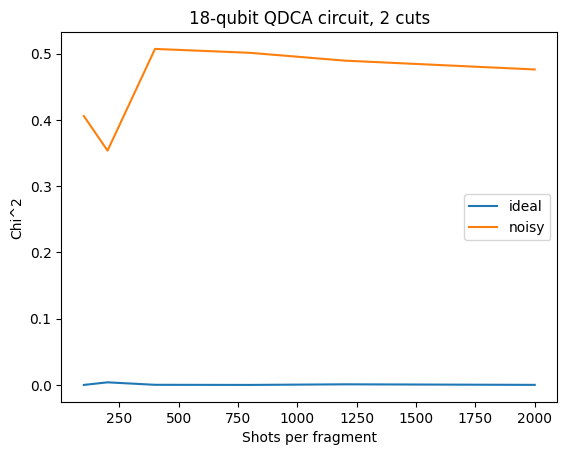

In [16]:
fig, ax = plt.subplots()

x_vals = sorted(ideal_sim_metrics.keys())
y_vals = [ideal_sim_metrics[shot]['nearest']['chi2'] for shot in x_vals]
ax.plot(x_vals, y_vals, label='ideal')

x_vals = sorted(noisy_sim_metrics.keys())
y_vals = [noisy_sim_metrics[shot]['nearest']['chi2'] for shot in x_vals]
ax.plot(x_vals, y_vals, label='noisy')

ax.set_ylabel('Chi^2')
ax.set_xlabel('Shots per fragment')
ax.set_title('18-qubit QDCA circuit, 2 cuts')
ax.legend()

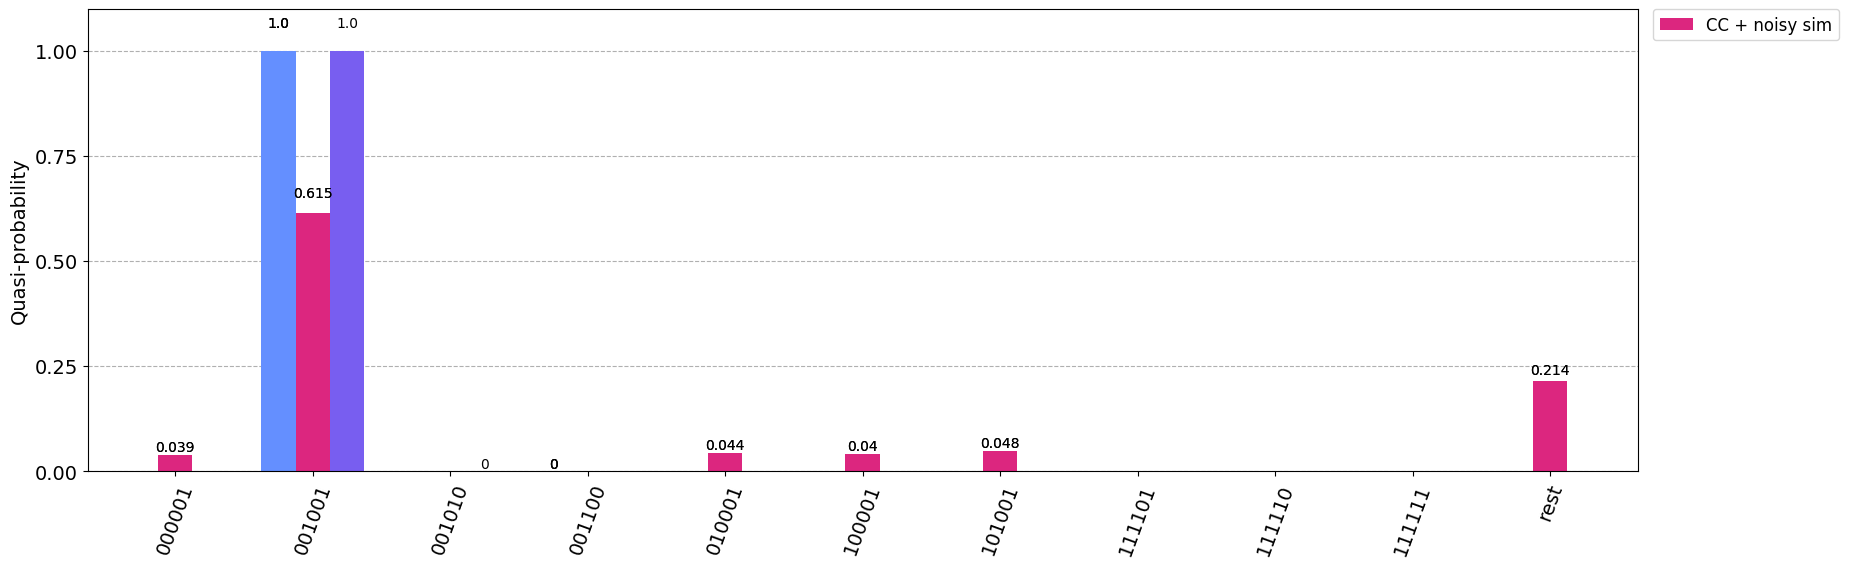

In [37]:
recon_dict_bitstrs = []
full_prob_dist = full_ideal_sim_result.quasi_dists[0].nearest_probability_distribution()
dists = [
    'QCE2023/runtime_results/ideal-sim_2000-shots_03-22-2023.pickle',
    'QCE2023/runtime_results/noisy-sim_2000-shots_03-22-2023.pickle'
]
labels = ['CC + ideal sim', 'CC + noisy sim']

recon_dists = []
num_qubits = []
for fname in dists:
    with open(fname, 'rb') as pklfile:
        data = pickle.load(pklfile)
    recon_probs = data['reconstructed_probs']
    recon_dists.append({i: prob for i, prob in enumerate(recon_probs)})
    num_qubits.append(data['circuit'].num_qubits)

recon_dict_bitstrs = []
for recon_dist, nq in zip(recon_dists, num_qubits):
    recon_dict_bitstrs.append(
        qiskit.result.ProbDistribution(data=recon_dist).binary_probabilities(num_bits=nq)
    )
    
recon_dict_bitstrs.append(full_prob_dist.binary_probabilities(num_bits=nq))
labels.append('Full ideal sim')
#recon_dict_bitstrs.append(full_noisy_prob_dist.binary_probabilities(num_bits=nq))
#labels.append('Full noisy')

# plot a histogram of the distributions
qiskit.visualization.plot_histogram(
    recon_dict_bitstrs,
    number_to_keep=5,
    figsize=(20, 6),
    sort="asc",
    legend=labels,
)

In [26]:
def plot_dist(dists, labels, cutoff=8, savefig=None, rotation=60):
    colors = ['tab:blue', 'tab:pink', 'tab:purple', 'tab:green', 'tab:red', 'tab:orange', 'black']
    #labels = ['CC + ideal sim', 'CC + noisy sim', 'Full circuit ideal sim', 'Full circuit noisy sim',
    #          'Algiers']
    fig, ax = plt.subplots(dpi=300)

    top_counts = []
    for dist in dists:
        top_counts.extend(sorted(dist.items(), key=lambda t: t[1], reverse=True)[:cutoff])

    xlabels = []
    for bitstr, p in sorted(top_counts, key=lambda t: t[1], reverse=True):
        if len(xlabels) < cutoff+1 and bitstr not in xlabels:
            xlabels.append(bitstr)
            
    xlabels = xlabels + ['rest']
    print(xlabels)
    
    width = 0.3
    for i, dist in enumerate(dists):
        xvals = [j*2 + width*i for j in range(len(xlabels))]
        yvals = [dist.get(bitstr, 0) for bitstr in xlabels if bitstr != 'rest']
        rest_prob = sum(dist.values()) - sum(yvals)
        yvals.append(rest_prob)
        ax.bar(xvals, yvals, label=labels[i], align='center', width=width, color=colors[i])
    ax.set_ylabel('Probability')
    
    xvals = [j*2 + 2.5*width for j in range(len(xlabels))]
    ax.set_xticks(xvals)
    ax.set_xticklabels(xlabels)
    ax.legend()
    ax.set_title(f'{circuit.num_qubits}-qubit QDCA circuit execution')
    plt.xticks(rotation=rotation, ha='center')
    
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()
    plt.close()

['001001', '101001', '010001', '001000', '100001', '000001', '001010', '011001', '001011', 'rest']


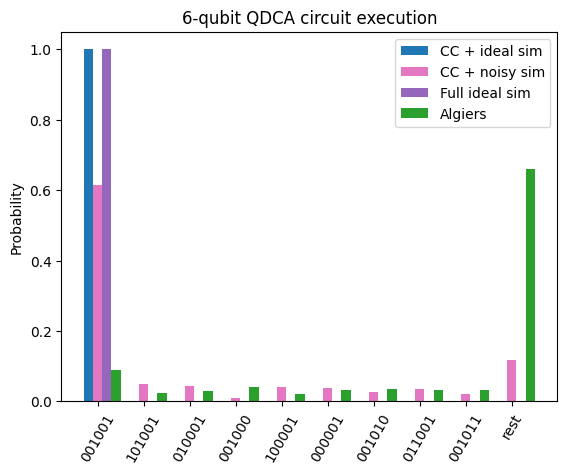

In [44]:
plot_dist(recon_dict_bitstrs, labels, savefig='QCE2023/QDCA_6qubits_simulation_testing.pdf')

### Full circuit evaluation on `ibm_algiers`

In [71]:
algiers_service = QiskitRuntimeService(
    channel="ibm_cloud",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/37803d76ada74566b6f0114bd5964846:d9a0fc42-0d7f-4bbf-9320-dff97f3c8ed8::"
)
print(algiers_service.backends())
print(algiers_service.programs())

[<IBMBackend('ibm_algiers')>, <IBMBackend('ibm_canberra')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]
[<RuntimeProgram('hello-world')>, <RuntimeProgram('sampler')>, <RuntimeProgram('estimator')>]


In [72]:
algiers_backend = algiers_service.get_backend("ibm_algiers")

In [73]:
config = algiers_backend.configuration()

In [74]:
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called ibm_algiers, and is on version 1.5.10. It has 27 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['cx', 'id', 'rz', 'sx', 'x'].


In [75]:
print(temp_circuit.count_ops())
temp_circuit.draw(fold=-1)

OrderedDict([('cx', 100), ('u1', 75), ('u3', 70), ('u2', 13), ('measure', 8), ('barrier', 1)])


┌─────────┐     ┌──────────────────────────┐     ┌─────────┐    ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐┌───────────────────────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                ┌─────────┐                                                                                                                                                        ┌───────────┐┌──────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ░ ┌─┐                     
   q_0: ──┤ U1(π/2) ├─────┤ U3(1.57094103234579,0,0) ├─────┤ U2(0,π) ├────┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,0,-3π/4) ├┤ U3(-1.57094103234579,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,π/2,π/4) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────■─────────────────■──────────────────┤ U1(π/2) ├────────────────■──────────────────────────────■────────────────────────────────────────■────────────■──────────────────────────────────────────■───────┤ U3(π,0,π) ├┤ U1(3.16658688134399) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [76]:
algiers_circuit = qiskit.compiler.transpile(temp_circuit, backend=algiers_backend, optimization_level=3)

In [77]:
print(algiers_circuit.depth())
print(algiers_circuit.count_ops())
algiers_circuit.draw(fold=-1)

335
OrderedDict([('rz', 224), ('cx', 176), ('sx', 94), ('x', 26), ('measure', 8), ('barrier', 1)])


ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                    ┌─────────┐       ┌────┐  ┌────────────────┐┌────┐┌───────┐                                                                                                                                                                                                                                                                                                                                                            ┌───┐┌───────────┐┌───┐                          ┌──────────┐┌────┐┌──────────┐        ┌───┐                                            ┌──────────┐┌────┐┌─────────────┐     ┌────┐┌─────────────┐   ┌────┐   ┌─────────────┐┌───┐     ┌───┐                      ┌─────────┐┌────┐                     ┌────┐  ┌──────────┐       ┌────┐  ┌─────────┐     ┌────┐                                                                                                              ┌─────────┐                                                 

#### Run full circuit

In [78]:
shots = 4000
with Session(algiers_service, backend="ibm_algiers") as session:
    sampler = Sampler(session=session)

    job = sampler.run(algiers_circuit, shots=shots)
    print(f"Job ID: {job.job_id()}")
    print(f"Job result: {job.result()}")
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: cgh0h20m8m2cp51dosgg
Job result: SamplerResult(quasi_dists=[{0: 0.00075, 1: 0.00325, 16: 0.0005, 17: 0.0035, 18: 0.0035, 19: 0.01025, 20: 0.00175, 21: 0.00325, 22: 0.00125, 23: 0.00375, 24: 0.00075, 25: 0.00525, 26: 0.00175, 27: 0.0055, 28: 0.00175, 29: 0.0015, 30: 0.00075, 31: 0.00175, 2: 0.002, 32: 0.00175, 33: 0.007, 34: 0.005, 35: 0.01725, 36: 0.00125, 37: 0.0035, 38: 0.0025, 39: 0.00625, 40: 0.00175, 41: 0.00175, 42: 0.00125, 43: 0.0035, 44: 0.001, 45: 0.00175, 46: 0.002, 47: 0.003, 3: 0.01025, 48: 0.002, 49: 0.00875, 50: 0.00425, 51: 0.01875, 52: 0.00275, 53: 0.0055, 54: 0.0025, 55: 0.00675, 56: 0.00175, 57: 0.00175, 58: 0.00175, 59: 0.00325, 60: 0.0015, 61: 0.00275, 62: 0.00125, 63: 0.00225, 4: 0.0005, 64: 0.002, 65: 0.00925, 66: 0.00425, 67: 0.0185, 68: 0.0025, 69: 0.004, 70: 0.0015, 71: 0.00525, 72: 0.002, 73: 0.002, 74: 0.0015, 75: 0.005, 76: 0.00175, 77: 0.0025, 78: 0.001, 79: 0.00275, 5: 0.00175, 80: 0.00125, 81: 0.0065, 82: 0.00425, 83: 0.012, 84: 0.00175, 85: 0.00

In [79]:
job = algiers_service.job('cgh0h20m8m2cp51dosgg')
print(job.result())

SamplerResult(quasi_dists=[{0: 0.00075, 1: 0.00325, 16: 0.0005, 17: 0.0035, 18: 0.0035, 19: 0.01025, 20: 0.00175, 21: 0.00325, 22: 0.00125, 23: 0.00375, 24: 0.00075, 25: 0.00525, 26: 0.00175, 27: 0.0055, 28: 0.00175, 29: 0.0015, 30: 0.00075, 31: 0.00175, 2: 0.002, 32: 0.00175, 33: 0.007, 34: 0.005, 35: 0.01725, 36: 0.00125, 37: 0.0035, 38: 0.0025, 39: 0.00625, 40: 0.00175, 41: 0.00175, 42: 0.00125, 43: 0.0035, 44: 0.001, 45: 0.00175, 46: 0.002, 47: 0.003, 3: 0.01025, 48: 0.002, 49: 0.00875, 50: 0.00425, 51: 0.01875, 52: 0.00275, 53: 0.0055, 54: 0.0025, 55: 0.00675, 56: 0.00175, 57: 0.00175, 58: 0.00175, 59: 0.00325, 60: 0.0015, 61: 0.00275, 62: 0.00125, 63: 0.00225, 4: 0.0005, 64: 0.002, 65: 0.00925, 66: 0.00425, 67: 0.0185, 68: 0.0025, 69: 0.004, 70: 0.0015, 71: 0.00525, 72: 0.002, 73: 0.002, 74: 0.0015, 75: 0.005, 76: 0.00175, 77: 0.0025, 78: 0.001, 79: 0.00275, 5: 0.00175, 80: 0.00125, 81: 0.0065, 82: 0.00425, 83: 0.012, 84: 0.00175, 85: 0.00475, 86: 0.00175, 87: 0.00425, 89: 0.0017

In [81]:
algiers_result = job.result()
algiers_prob_dist = algiers_result.quasi_dists[0].nearest_probability_distribution()

In [82]:
# save results
with open(f'QCE2023/runtime_results/QDCA-8qubit-results/algiers-qpu_fullcirc_{shots}-shots_03-27-2023.pickle', 'wb') as pklfile:
    data_dict = {
        'graphfile': target_graph,
        'G': G,
        'params': params,
        'circuit': circuit,
        'compiled_circuit':algiers_circuit,
        'job_id':job.job_id(),
        'job_result':job.result(),
        'nearest_distribution':algiers_prob_dist,
        'full_dist': algiers_prob_dist.binary_probabilities(num_bits=circuit.num_qubits)
    }
    pickle.dump(data_dict, pklfile)

### Circuit cutting evaluation on `ibm_algiers`

In [83]:
#transpile_options = TranspilationOptions(layout_method='sabre', routing_method='sabre')
shots = 2000
algiers_options = Options(
    execution={"shots":shots},
    optimization_level=3,
#    transpilation=transpile_options,
)

In [84]:
num_threads = 2
backend_names = ['ibm_algiers'] * 2

algiers_recon_dist, algiers_cuts = remote_runtime.local_cut_sim_reconstruct(
    circuit,
    subgraph_dict,
    cut_nodes,
    algiers_options,
    backend_names,
    algiers_service,
    num_threads,
)

--------------------
subcircuit 0
ρ qubits = 0, O qubits = 1, width = 4, effective = 3, depth = 68, size = 97
      ┌─────────┐ ┌──────────────────────────┐┌─────────┐┌───┐┌──────────┐┌───┐»
q_0: ─┤ U1(π/2) ├─┤ U3(1.57094103234579,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├»
      ├─────────┤ ├──────────────────────────┤├─────────┤└─┬─┘└──────────┘└─┬─┘»
q_1: ─┤ U1(π/2) ├─┤ U3(4.71213387630102,0,0) ├┤ U2(0,π) ├──┼────────────────┼──»
     ┌┴─────────┴┐└──────────────────────────┘└─────────┘  │                │  »
q_2: ┤ U3(π,0,π) ├─────────────────────────────────────────┼────────────────■──»
     ├───────────┤                                         │                   »
q_3: ┤ U3(π,0,π) ├─────────────────────────────────────────■───────────────────»
     └───────────┘                                                             »
«     ┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐»
«q_0: ┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,0,-3π/4) ├»
«     └─────────┘└─┬─┘└──────────┘└─┬─┘└─

In [85]:
algiers_metrics, exact_probabilities = verify(circuit, algiers_recon_dist)
algiers_metrics

{'nearest': {'chi2': 1.7252608044773552,
  'Mean Squared Error': 0.0033909705834336123,
  'Mean Absolute Percentage Error': 2837828542116261.5,
  'Cross Entropy': 2.6070781886288197,
  'HOP': 0.7426386250000004},
 'naive': {'chi2': 1.7252608044773552,
  'Mean Squared Error': 0.0033909705834336123,
  'Mean Absolute Percentage Error': 2837828542116261.5,
  'Cross Entropy': 2.6070781886288197,
  'HOP': 0.7426386250000004}}

In [86]:
temp_dist = {i: prob for i, prob in enumerate(algiers_recon_dist)}
recon_dist = qiskit.result.ProbDistribution(data=temp_dist).binary_probabilities(num_bits=circuit.num_qubits)    

In [87]:
# save results
with open(f'QCE2023/runtime_results/QDCA-8qubit-results/algiers-qpu_{max_cuts}cuts_{shots}-shots_03-27-2023.pickle', 'wb') as pklfile:
    data_dict = {
        'graphfile': target_graph,
        'G': G,
        'max_cuts': max_cuts,
        'params': params,
        'circuit': circuit,
        'subgraph_dict': subgraph_dict,
        'cut_nodes': cut_nodes,
        'hot_nodes': hot_nodes,
        'active_mixers': active_mixers,
        'reconstructed_probs': algiers_recon_dist,
        'cuts': algiers_cuts,
        'metrics': algiers_metrics,
        'recon_dist': recon_dist
    }
    pickle.dump(data_dict, pklfile)

### Plot the results

In [22]:
def load_dist(filename):
    with open(filename, 'rb') as pklfile:
        data = pickle.load(pklfile)
    if 'full_dist' in data.keys():
        return data['full_dist']
    elif 'recon_dist' in data.keys():
        return data['recon_dist']
    else:
        raise Exception('Incorrectly formatted data pickle!')

In [40]:
filenames = [
    'runtime_results/QDCA-8qubit-results/ideal-sim_fullcirc_4000-shots_03-27-2023.pickle',
    'runtime_results/QDCA-8qubit-results/ideal-sim_1cuts_2000-shots_03-27-2023.pickle',
    'runtime_results/QDCA-8qubit-results/noisy-sim_fullcirc_4000-shots_04-03-2023.pickle',
    'runtime_results/QDCA-8qubit-results/noisy-sim_1cuts_2000-shots_04-03-2023.pickle',
    'runtime_results/QDCA-8qubit-results/algiers-qpu_fullcirc_4000-shots_03-27-2023.pickle',
    'runtime_results/QDCA-8qubit-results/algiers-qpu_1cuts_2000-shots_03-27-2023.pickle',
]
labels = [
    'Full circ, ideal sim (4000 shots)',
    'w/ 1 cut, ideal sim (2000 shots/subcirc)',
    'Full circ, noisy sim (4000 shots)',
    'w/ 1 cut, noisy sim (2000 shots/subcirc)',
    'Full circ, ibm_algiers (4000 shots)',
    'w/ 1 cut, ibm_algiers (2000 shots/subcirc)',
]
dists = [load_dist(fn) for fn in filenames]

In [140]:
def plot_broken_dist(dists, labels, cutoff=8, savefig=None, rotation=60, botbreak=0.2, topbreak=0.8,
                     colors=None):
    if not colors:
        colors = ['tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:blue', 'tab:pink']
    #labels = ['CC + ideal sim', 'CC + noisy sim', 'Full circuit ideal sim', 'Full circuit noisy sim',
    #          'Algiers']
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, dpi=300)
    
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x', which='both', bottom=False)
    ax2.spines['top'].set_visible(False)
    
    ax2.set_ylim(0, botbreak)
    ax1.set_ylim(topbreak, 1.02)
    ax1.set_yticks(np.arange(topbreak, 1.01, 0.1))
    
    #axBetween.spines['top'].set_visible(False)
    #axBetween.spines['bottom'].set_visible(False)
    #axBetween.set_ylim(botbreak, topbreak)
    #axBetween.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    #axBetween.tick_params(axis='y', which='both', left=False)

    top_counts = []
    for dist in dists:
        top_counts.extend(sorted(dist.items(), key=lambda t: t[1], reverse=True)[:cutoff])

    xlabels = []
    for bitstr, p in sorted(top_counts, key=lambda t: t[1], reverse=True):
        if len(xlabels) < cutoff+1 and bitstr not in xlabels:
            xlabels.append(bitstr)
            
    xlabels = xlabels + ['rest']
    print(xlabels)
    
    width = 0.3
    for i, dist in enumerate(dists):
        xvals = [j*2 + width*i for j in range(len(xlabels))]
        yvals = [dist.get(bitstr, 0) for bitstr in xlabels if bitstr != 'rest']
        rest_prob = sum(dist.values()) - sum(yvals)
        yvals.append(rest_prob)
        print(labels[i], yvals[:3])
        ax1.bar(xvals, yvals, label=labels[i], align='center', width=width, color=colors[i])
        ax2.bar(xvals, yvals, label=labels[i], align='center', width=width, color=colors[i])
        
    xvals = [j*2 + 2.5*width for j in range(len(xlabels))]
    ax2.set_xticks(xvals)
    ax2.set_xticklabels(xlabels, fontsize=16)
    plt.xticks(rotation=rotation, ha='center')
    ax2.set_ylabel('Probability', fontsize=18)
    ax2.yaxis.set_label_coords(-0.12, 1.1)
    ax1.legend(loc='center', fontsize=13)
    ax1.set_title(r'8-qubit QDCA circuit execution on $ibm\_algiers$', fontsize=17)
    ax1.tick_params(axis='y', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()
    plt.close()

['10100011', '00100011', '10101011', '10000011', '01100011', '00110011', '10100001', '00010011', '01000011', 'rest']
Full circ, ideal sim (4000 shots) [1.0, 0, 0]
w/ 1 cut, ideal sim (2000 shots/subcirc) [0.9998055, 0.0, 0.00019450000000009737]
Full circ, noisy sim (4000 shots) [0.0625, 0.02925, 0.01475]
w/ 1 cut, noisy sim (2000 shots/subcirc) [0.06287225, 0.02588775, 0.011321250000000005]
Full circ, ibm_algiers (4000 shots) [0.04375, 0.01725, 0.011]
w/ 1 cut, ibm_algiers (2000 shots/subcirc) [0.07374975, 0.034556, 0.0307795]


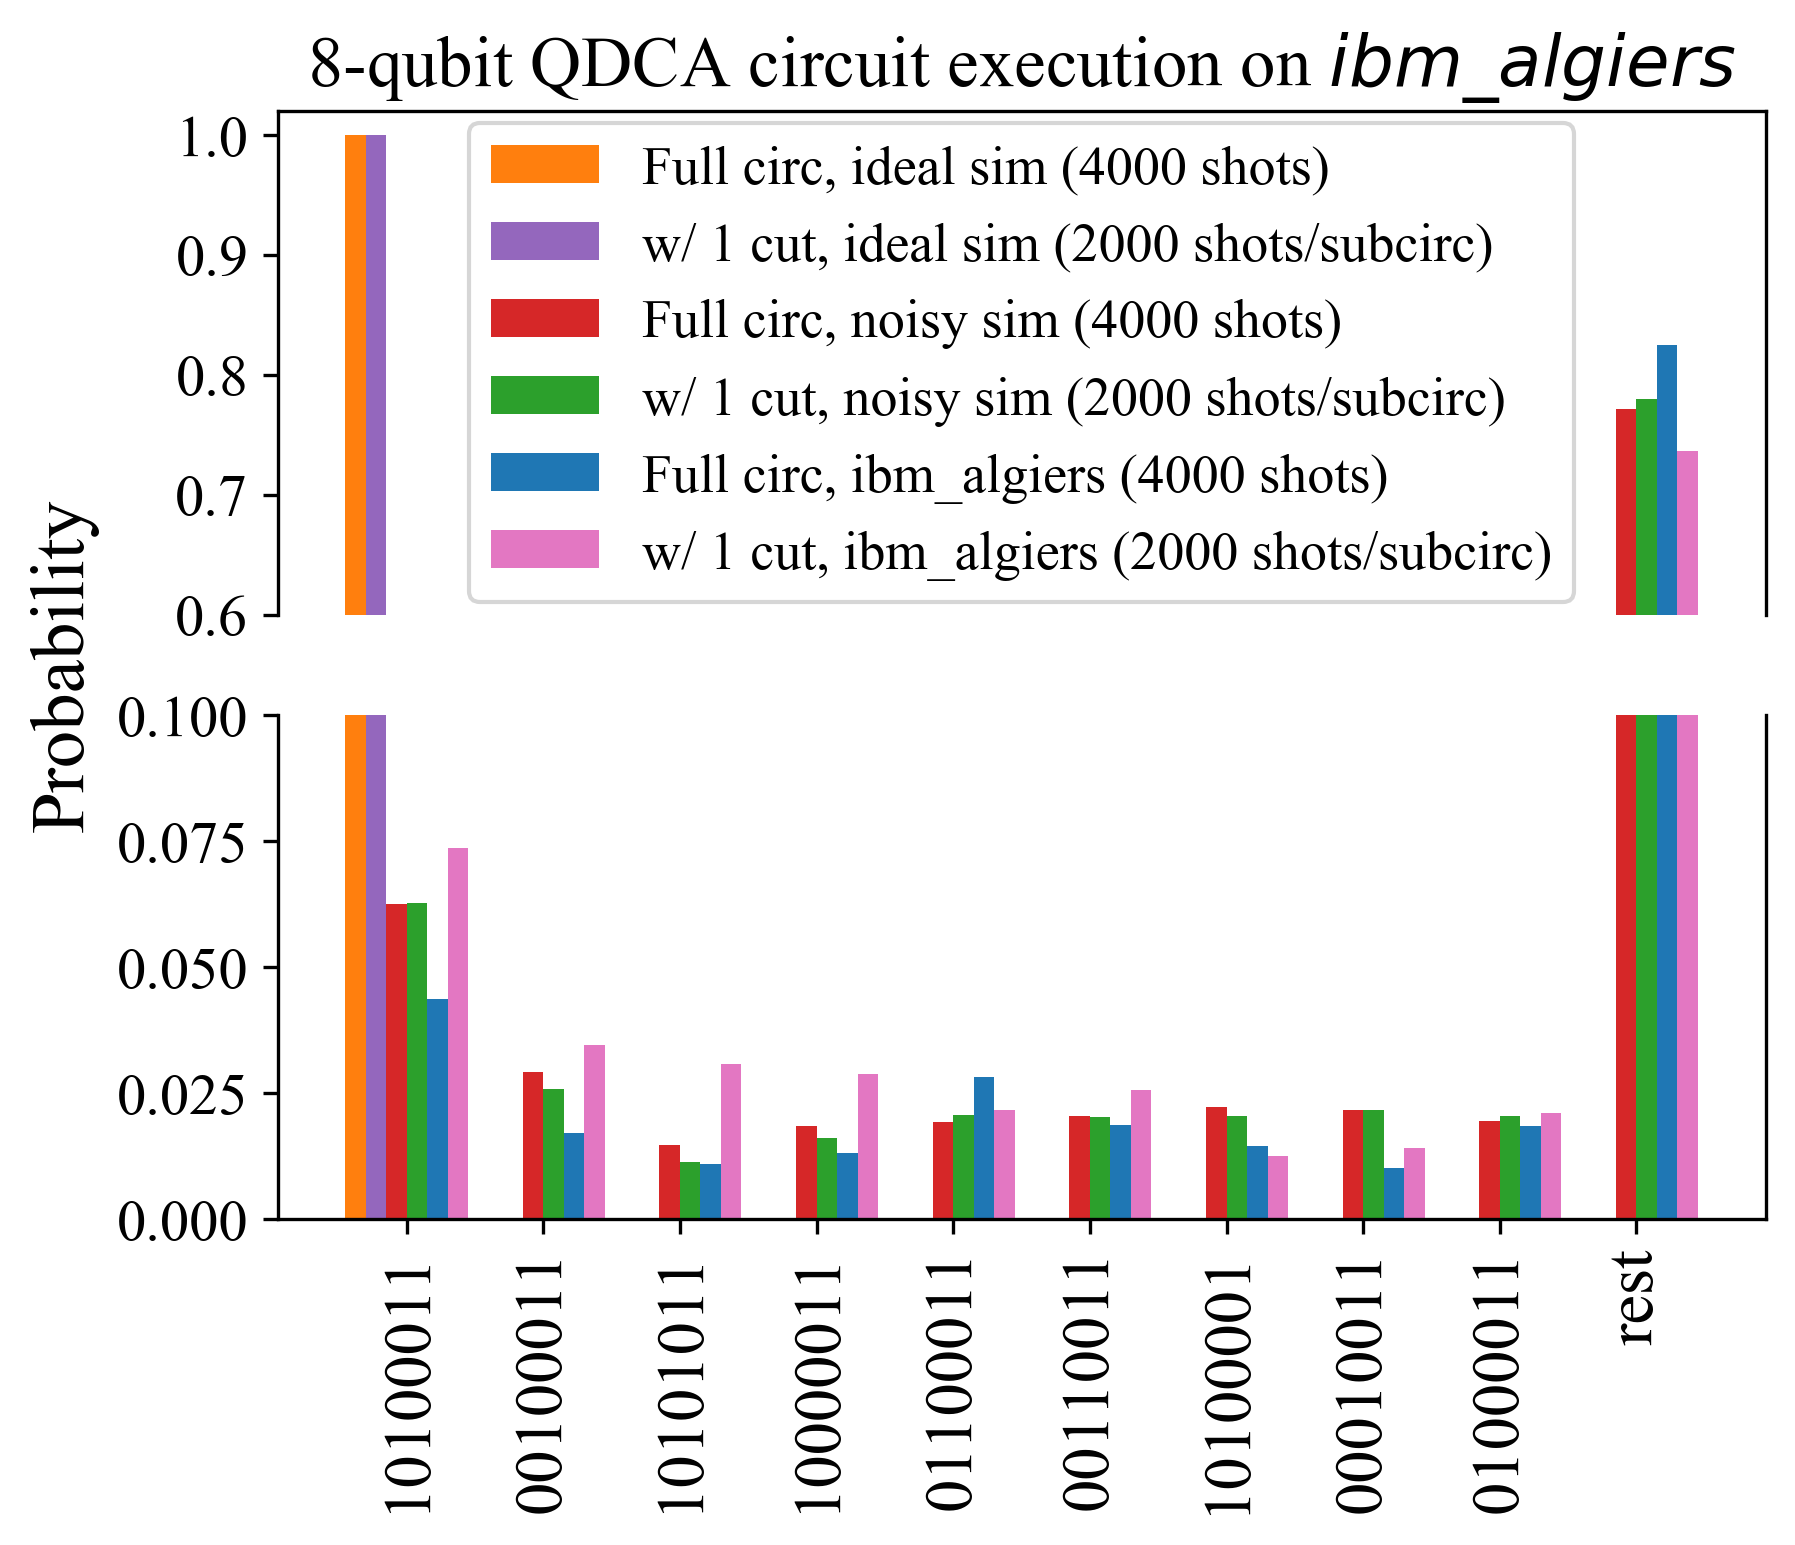

In [141]:
plot_broken_dist(
    dists, labels,
    botbreak=0.1, topbreak=0.6,
    rotation=90,
    savefig='figures/8qubit_noisy_ideal_qpu_comparison.pdf')

['10100011', '00100011', '10101011', '10000011', '01100011', '00110011', '01000011', '10010011', '00101011', '11100011', '00000011', '10100010', '10110011', '10001011', '00111011', '00001011', '10100001', '00010011', '01001011', '01010011', '01110011', 'rest']
Full circ, ibm_algiers (4000 shots) [0.04375, 0.01725, 0.011]
w/ 1 cut, ibm_algiers (2000 shots/subcirc) [0.07374975, 0.034556, 0.0307795]


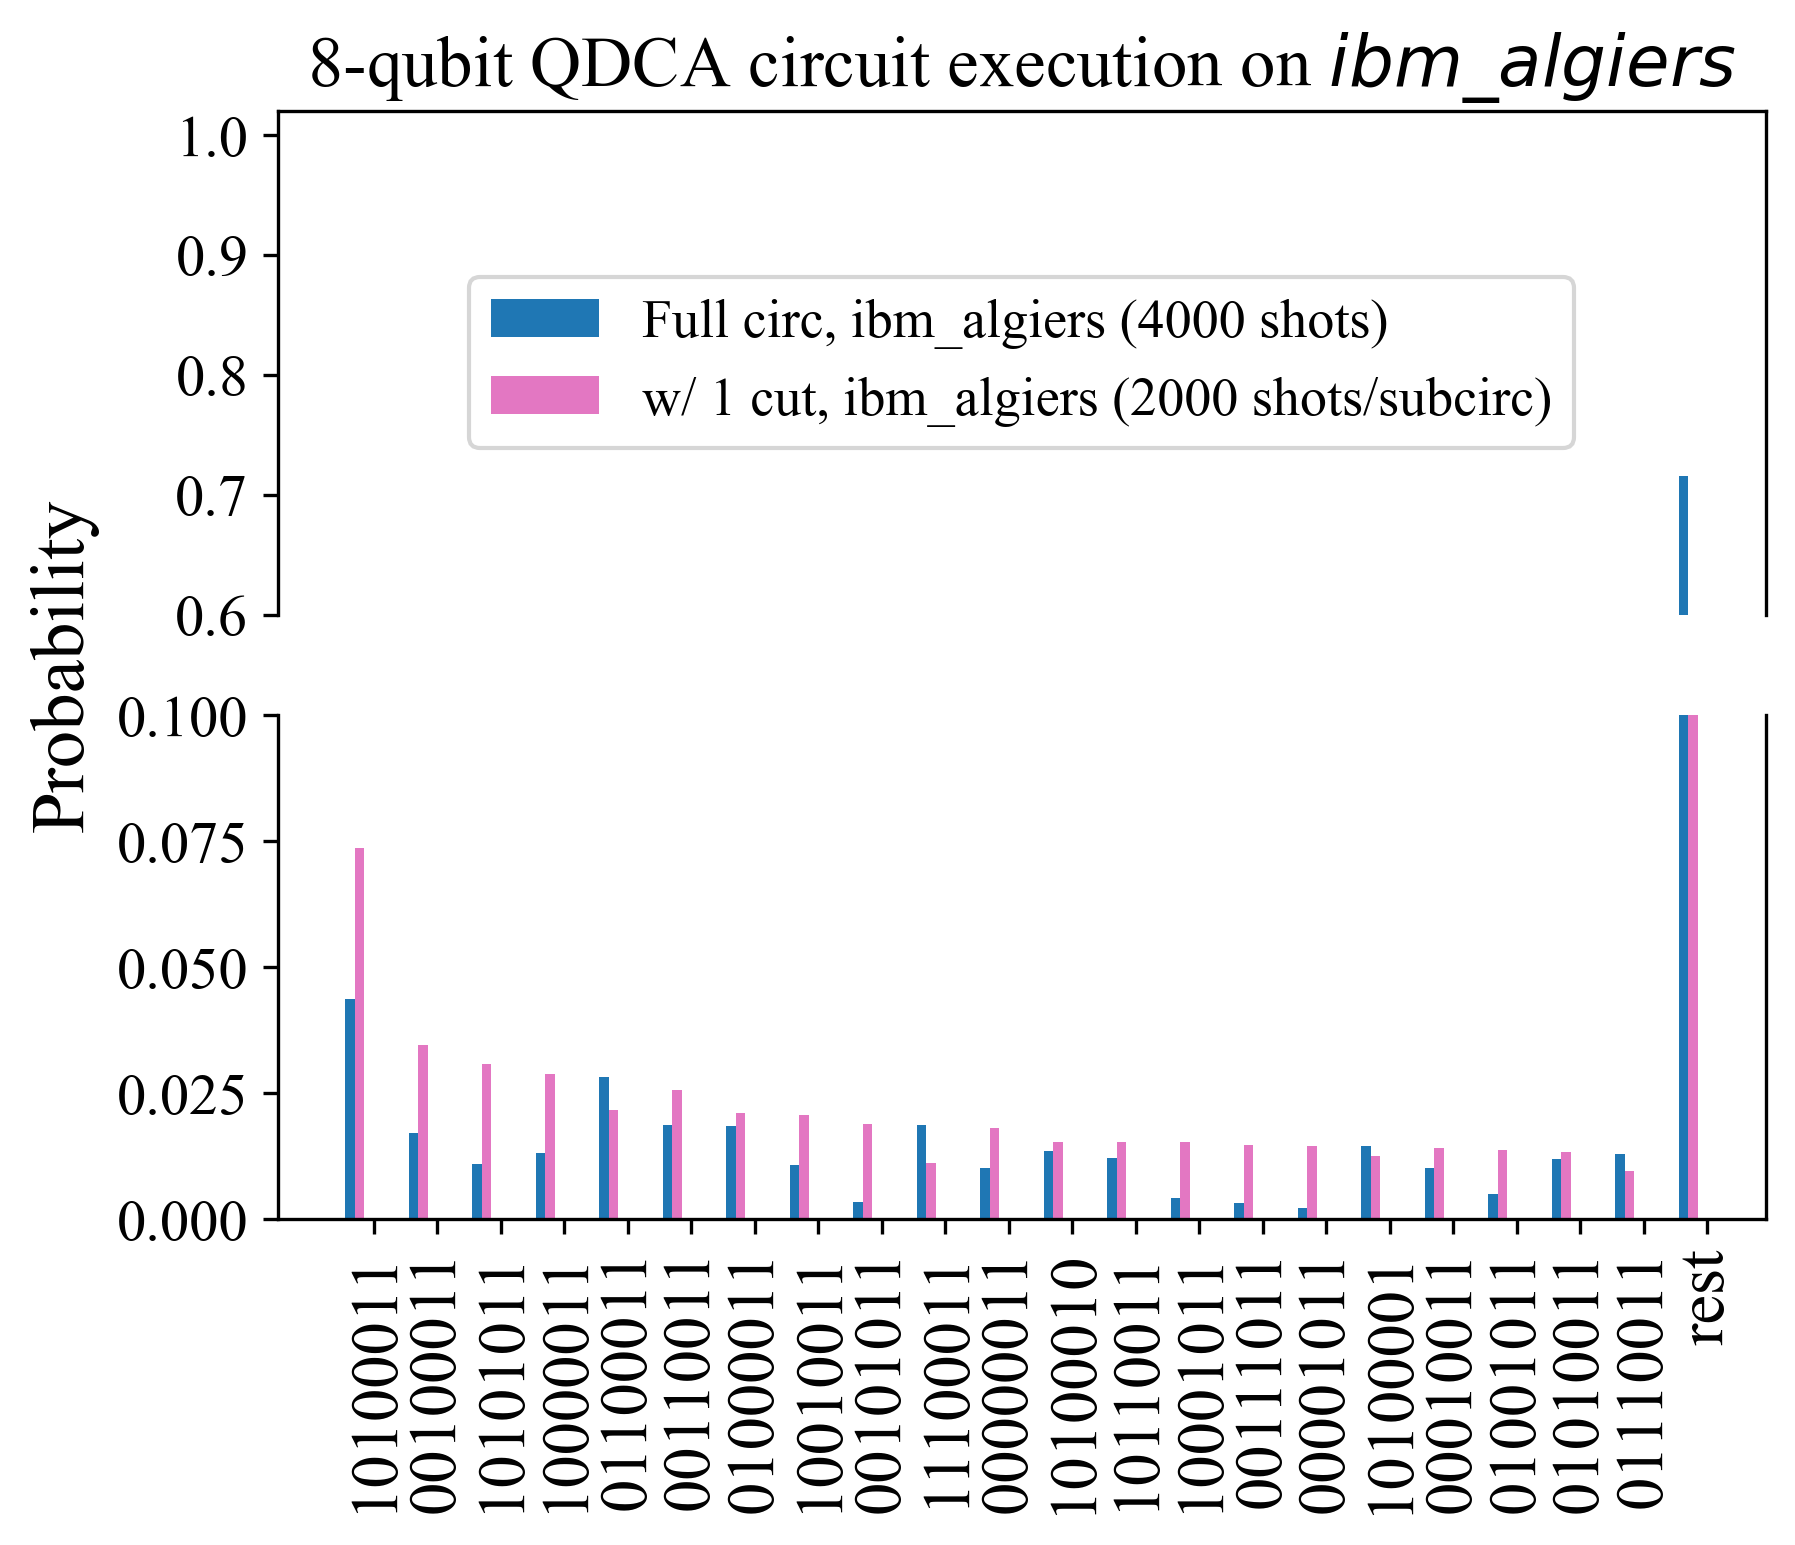

In [143]:
plot_broken_dist(
    dists[-2:],
    ['Full circ, ibm_algiers (4000 shots)', 'w/ 1 cut, ibm_algiers (2000 shots/subcirc)'],
    cutoff=20,
    rotation=90,
    savefig='figures/algiers_dist.pdf',
    colors=['tab:blue', 'tab:pink'],
    botbreak=0.1,
    topbreak=0.6,
)